# Design of the comparative chapters of my Thesis

This Lab uses the Hora library to evaluate different Thesis design options.

The modelling languages compared are qualititive.

## Initialisation

Initialise the lab with the Hora library.

In [1]:
from hypernetworks.core.Hypernetwork import Hypernetwork
from hypernetworks.core.Hypersimplex import VERTEX, ALPHA, BETA
from hypernetworks.utils.HTCompiler import load_parser, compile_hn
from hypernetworks.utils.HTGraph import draw_hn
from hypernetworks.utils.HTSearch import what_is_it, bottom_up, get_search_paths, top_down
from hypernetworks.utils.HTTools import get_subHn_by_semantic_boundary

from IPython.display import Image, display
#from rich import print

parser = load_parser()

This function will convert the *hierarchical soup* to a Hypernetwork (Hn).

In [2]:
def get_peaks(sub_hn):
    peaks = []
    for name, hs in sub_hn.hypernetwork.items():
        if len(hs.partOf) == 0:
            peaks.append(name)

    return peaks

In [3]:
def get_boundaries(hn):
    boundaries = set()
    
    for name, hs in hn.hypernetwork.items():
        boundaries = boundaries.union(hs.B)
        
    return list(boundaries)

In [4]:
def soup_to_hn(soup):
    hn = Hypernetwork()
    temp = ""

    for line in soup.split('\n'):
        temp_line = ""
        boundary = ""
        
        if line[:line.find(";")].replace(" " ,"").replace("\t", ""):
            temp_line = line[:line.find(";") + 1]

        if ">>" in line:
            boundary = line[line.find(">>") + 2:].replace(" ", "")
            if "#" in boundary:
                boundary = boundary[:boundary.find("#")]
        

        if "|" in line:
            temp += temp_line.replace(": |", "={").replace("|;", (";B(" + boundary + ")}") if boundary else "}").replace(" | ", ", ")

        else:
            temp += temp_line.replace(": ", "=<").replace(";", (";B(" + boundary + ")>") if boundary else ">")
            
        temp += "\n"

    compile_hn(hn, parser, temp)
    
    return hn

This function attempts to convert the Hn into an English statement of work.  At this time it is very simple and needs considerable work to perfom this transformation.

In [5]:
def chapter_structure(subHn):
    visited = []
    
    def _find_vertices():
        vertices = []
    
        for name, vertex in subHn.hypernetwork.items():
            if vertex.hstype in [VERTEX]:
                vertices.append(name)
                
        return vertices
    
    def _to_str_list(lst, hstype=ALPHA):
        if len(lst) > 1:
            lst = ", ".join(lst[:len(lst)-1]) + (" and " if hstype==ALPHA else " or ") + str(lst[len(lst)-1:][0])
            
        else:
            lst = lst[0]
            
        return lst
    
    def _italic(txt):
        return txt
        return "[italic]{}[/italic]".format(txt)
    
    def _common_topics(hs, parent="", indent=0):
        partOf = list(hs.partOf)
        intersection = set()
        difference = set()
        multiple = False
        displayed_something = False
        hstype = hs.hstype
        
        for whole in partOf:
            _common_topics(subHn.hypernetwork[whole], indent=indent+1)
            
            if len(intersection) == 0:
                intersection = set(subHn.hypernetwork[whole].simplex)

            else:
                multiple = True
                intersection = intersection.intersection(set(subHn.hypernetwork[whole].simplex))
        
        if partOf not in visited:
            visited.append(partOf)
            
            if multiple:
                displayed_something = True
                print((indent*"\t")+_italic(_to_str_list(partOf)), "have/has", _italic(_to_str_list(list(intersection), hstype)) + " in common.")

                if len(partOf) > 2:
                    print((indent*"\t"), "   but individually:")
                    indent += 1
                    for i, whole in enumerate(partOf):
                        intersection = set()

                        for inner in partOf[i+1:]:
                            if whole != inner:
                                intersection = set(subHn.hypernetwork[whole].simplex)
                                intersection = intersection.intersection(set(subHn.hypernetwork[inner].simplex))
                                
                                temp_whole = set(subHn.hypernetwork[whole].simplex).difference(intersection)
                                temp_inner = set(subHn.hypernetwork[inner].simplex).difference(intersection)

                                difference = temp_whole.difference(temp_inner).union(temp_inner.difference(temp_whole))
                                
                                print((indent*"\t")+_italic(whole) + " and " + _italic(inner), "have/has", _italic(_to_str_list(list(intersection))) 
                                      + " in common" + ("." if len(difference)==0 else ""))

                                if len(temp_whole) > 0:
                                    print(((indent+1)*'\t')+"  ...", _italic(whole), "have/has", _italic(_to_str_list(list(temp_whole), hstype)), "differences")
                                if len(temp_inner) > 0:
                                    print(((indent+1)*'\t')+"  ...", _italic(inner), "have/has", _italic(_to_str_list(list(temp_inner), hstype)), "differences")

            else:
                if partOf and len(intersection) > 0:
                    displayed_something = True
                    phrase = "has the subtopics:" if hstype == ALPHA else "can be one of these subtopics:"
                    print(_italic(_to_str_list(partOf)), phrase, _italic(_to_str_list(list(intersection), hstype)) + ".")
                    
        return displayed_something

    vertices = _find_vertices()

    for vertex in vertices:
        if _common_topics(subHn.hypernetwork[vertex]):
            print()

A simple function for providing a common output of the various Hn's.

In [6]:
def output_hierarchy(hn):
    def _output_hierarchy(hs, level):
        print(level * "|-- " + hs.vertex, "Boundaries:", hs.B)
        
        for name in hs.simplex:
            temp_hs = hn.hypernetwork[name]
            _output_hierarchy(temp_hs, level+1)
        
    peaks = get_peaks(hn)
    
    for peak in peaks:
        _output_hierarchy(hn.hypernetwork[peak], 0)
        
    print()

In [7]:
def draw_hn_image(subHn, fname, width, height, direction="LR", suppress=False, show_levels=False, show_boundary=True, show_vertex=True):
    if not suppress:
        output_hierarchy(subHn)
#         chapter_structure(subHn)
#         for name, hs in sorted(subHn.hypernetwork.items()):
#             if hs.simplex:
#                 print(hs)

    if not subHn.empty:
        draw_hn(subHn, fname=fname, view=False, split_camel=False, svg=True, direction=direction, show_levels=show_levels, 
                show_boundary=show_boundary, show_vertex=show_vertex)
        
    else:
        return
        
    return Image(filename=fname+".png", width=width, height=height)

# Function-Behaviour-Structure (FBS)

As an approach to design we will use Gero's FBS framework, illustrated below, to find the right design for this Thesis *System*.

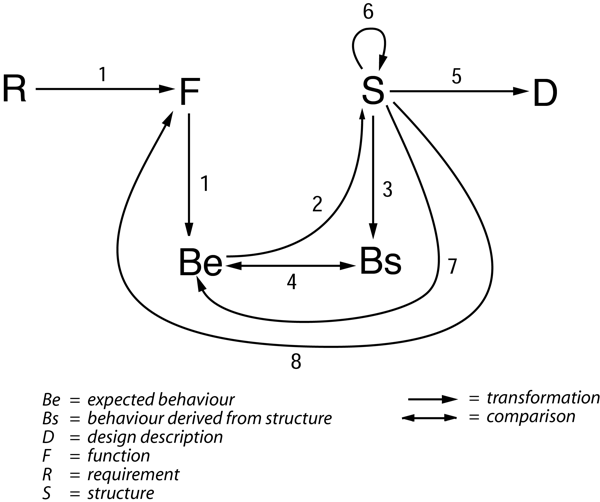

In [8]:
Image("FBSFramework.png", width=500, height=500)

## Soup (R)

In this aproach the first step is to define the Hierarchical Soup (R).  This means identifying all topics and subtopics as simple descriptions.  The language is structured but informal and consists of simple *and* and *or* lists.  The soup language takes the form: "$<$*topic*$>$: $<$*subtopic*$>$, ...;" for disjunction - $\vee$, and "$<$*topic*$>$: |$<$*subtopic*$>$ | ...|;" for logical conjunction - $\wedge$.  This creates an unbounded backcloth that, as it turned out, was difficult to search without so,e form of simple constraints.  To resolve this we introduced Boundaries into the soup, where ">> $<$*boundary*$>$" was used to allocate the given topic and its subtopics to the specified boundary.

Care has to be taken that we correctly define each soup item to be transformed into $\alpha$ and $\beta$ aggregations.  It should be noted that all *relations* $R$, are *annonymous*, as the Hs can be of any structure and we are only interested in the simple relations amongst the vertices and Hs.

In [9]:
soup = """
	Design: |Function | Behaviour | Structure|; >> Design # Design elements.
    Function: |OO-function | HT-function|; >> Function #
    Behaviour: |OO-behaviour | FM-behaviour | HT-behaviour|; >> Behaviour
    Structure: |OO-structure | FO-structure | FM-structure | HT-structure|; >> Structure

    normalise: |categorisation | containment|; >> Structure # The different types of structure.
	structures: |hierarchy | heterarchy | relational | graph | multilevel | multidimensional | taxonomy|; >> Structure # types of structure.
    behaviour: |internal | external|;  >> Behaviour
	complexity: emergence, hierarchy; >> Complexity # Aspects of complexity.
	complicated: ;
	modelling: |simple-modelling | complicated-modelling | qualitative | quantitative|; >> Model
	model: |abstract | concrete|; >> Model  # A model can be abstract or concrete. 
    actions: |proof | mathematics|;  >> Actions
    abstraction: |abstract | concrete | instatiation|;  >> Model, Structure
    ontological: nomenclature, ubiquitous-language;  >> Model
    mathematics: |graph-algebra | HT-algebra | set-algebra | propositional-logic | predicate-logic | logic|;  >> Actions
    set-algebra: |union | intersection | subset | difference | member-of|;
	logic: |AND | OR | NOT|;
    nodes: |node | vertex | class | object | schema|;
    links: |Rel | association | aggregation | composition | link | edge|;
    
    ; Categories
	multidimensional: |n-ary | polygons|;  >> Structure
	taxonomy: |hierarchy | beta-aggregation|; >> Structure
	part-of: |mereology | meronymy|;  >> Model
	alternatives: |OO | FO | FM|;
	concepts: |integrity | proof | categorisation | containment | impiicit-R | explicit-R|;

    ; Object Orientation
    OO: OO-elements, OO-notation, OO-concepts, OO-uses, OO-actions, OO-design, OO-ontology; >> OO, Design
    OO-notation: diagramatic; >> Notation
	OO-concepts: |inheritance | abstraction | polymorphism | encapsulation | categorisation | containment | explicit-R | ontological | instatiation | concrete | abstract|; >> Model
	OO-uses: |analysis | design | programming | software-specification|;
	OO-actions: |polymorphism | proof|;  >> Actions
	OO-design: OO-function, OO-behaviour, OO-structure; >> Design
    OO-function: |use-cases|; >> Function
    OO-behaviour: methods, internal;  >> Behaviour
    OO-structure: inheritance, categorisation, containment, relational, taxonomy, OO-elements; >> Structure
    OO-structures: |graph | hierarchical | heterarchical|; >> Structure
	OO-elements: |class | object | association | n-ary|; >> Structure
    OO-ontology: class, object, categorisation, containment; >> Ontology

    ; Formal Methods
    FM: FM-elements, FM-notation, FM-concepts, FM-uses, FM-actions, FM-design;  >> FM
    FM-notation: mathematical;  >> Notation
	FM-concepts: |containment | explicit-R | abstract|; >> Model
	FM-uses: |software-specification|;
	FM-actions: |proof | set-algebra | propositional-logic | predicate-logic | logic|;  >> Actions
	FM-design: FM-behaviour, FM-structure;  >> Design
    FM-behaviour: functional-schema, internal;  >> Behaviour
    FM-structure: FM-elements;  >> Structure
    FM-structures: |hierarchical | heterarchical|; >> Structure
	FM-elements: |schema|; >> Structure

    ; Formal Ontologies
    FO: FO-elements, FO-notation, FO-concepts, FO-uses, FO-actions, FO-design;  >> FO, Ontology
    FO-notation: mathematical;  >> Notation
	FO-concepts: |taxonomy | part-of | categorisation | containment | explicit-R | ontological | instatiation | concrete | abstract|; >> Model
	FO-actions: |search | graph-algebra | emergence | proof|;  >> Actions
	FO-uses: |nomenclature | ubiquitous-language|;
	FO-design: FO-structure;  >> Design
    FO-structure: relational, taxonomy, FO-elements;  >> Structure
    FO-structures: |graph | hierarchical | heterarchical|; >> Structure
	FO-elements: |object | class | binary | DL|;  >> Structure

    HT: HT-elements, HT-notation, HT-concepts, HT-uses, HT-actions, HT-design, HT-ochestration;  >> HT
    HT-notation: mathematical;  >> Notation
	HT-concepts: |backcloth | traffic | soup | n-ary | multilevel | multidimensional | AND | OR | categorisation | containment | relational | integrity | explicit | implicit | ontological | concrete | abstract|; >> Model
	HT-actions: |search | emergence | HT-algebra|;  >> Actions
	HT-uses: |extended-ontology | orchestration | analysis | design | canonical-language|;
	HT-design: HT-function, HT-behaviour, HT-structure;  >> Design
	HT-algebra: |hyperunion | hyperintersection | sub-Hn | member-of | logic|;  >> Actions
    HT-behaviour: Hn, Hs, Rel, external;  >> Behaviour
    HT-structure: categorisation, containment, relational, HT-elements, multilevel, multidimensional, heterarchy, hierarchy, n-ary, taxonomy, HT-elements; >> Structure, Ontology, Canonical-Language
    HT-structures: |graph | hierarchical | heterarchical | multilevel | multidimentional|; >> Structure
	HT-elements: |Hn | Hs | simplex | vertex | Rel | time | alpha-aggregation | beta-aggregation | boundary | property|;  >> Structure
    HT-function: |soup | Hn|;  >> Function
    HT-ochestration: HT-elements, traffic; >> Orchestration
    
    DAG: DAG-elements, DAG-concepts; >> Orchestration
    DAG-concepts: graph;
    DAG-elements: nodes, directed-edge;

    traffic: |phi-function | psi-function|;
	class: |schema | universal | boundary|;
	inheritance: hierarchy, polymorphism, abstraction;  >> Structure
	encapsulation: |data-hiding | method|;
	relations: |binary | n-ary | inheritance | association | explicit | implicit|;  >> Structure
	association: |aggregation | composition | n-ary|;
	notation: |mathematical | diagramatic|;  >> Notation
	soup: |hierarchy | heterarchy|;  >> Structure
	Rel: | binary | n-ary | DL | lambda-calc | logical | multilevel | alpha-aggregation | beta-aggregation|;  >> Structure
	
	AND: | conjunction | alpha-aggregation|;
	OR: | disjunction | beta-aggregation|;
"""

## Function (F)

In terms of designing a Thesis *system*, *Function* (F) should be interpreted as "*what it should say*".

Using a simple function *soup_to_hn* defined above the soup is converted to the Hn backcloth for *Function*.  Nothing more than this conversion function and the Hora HT compiler is required to create the *function* backcloth.  In effect the Hn and all its relations *emerge* from the soup.

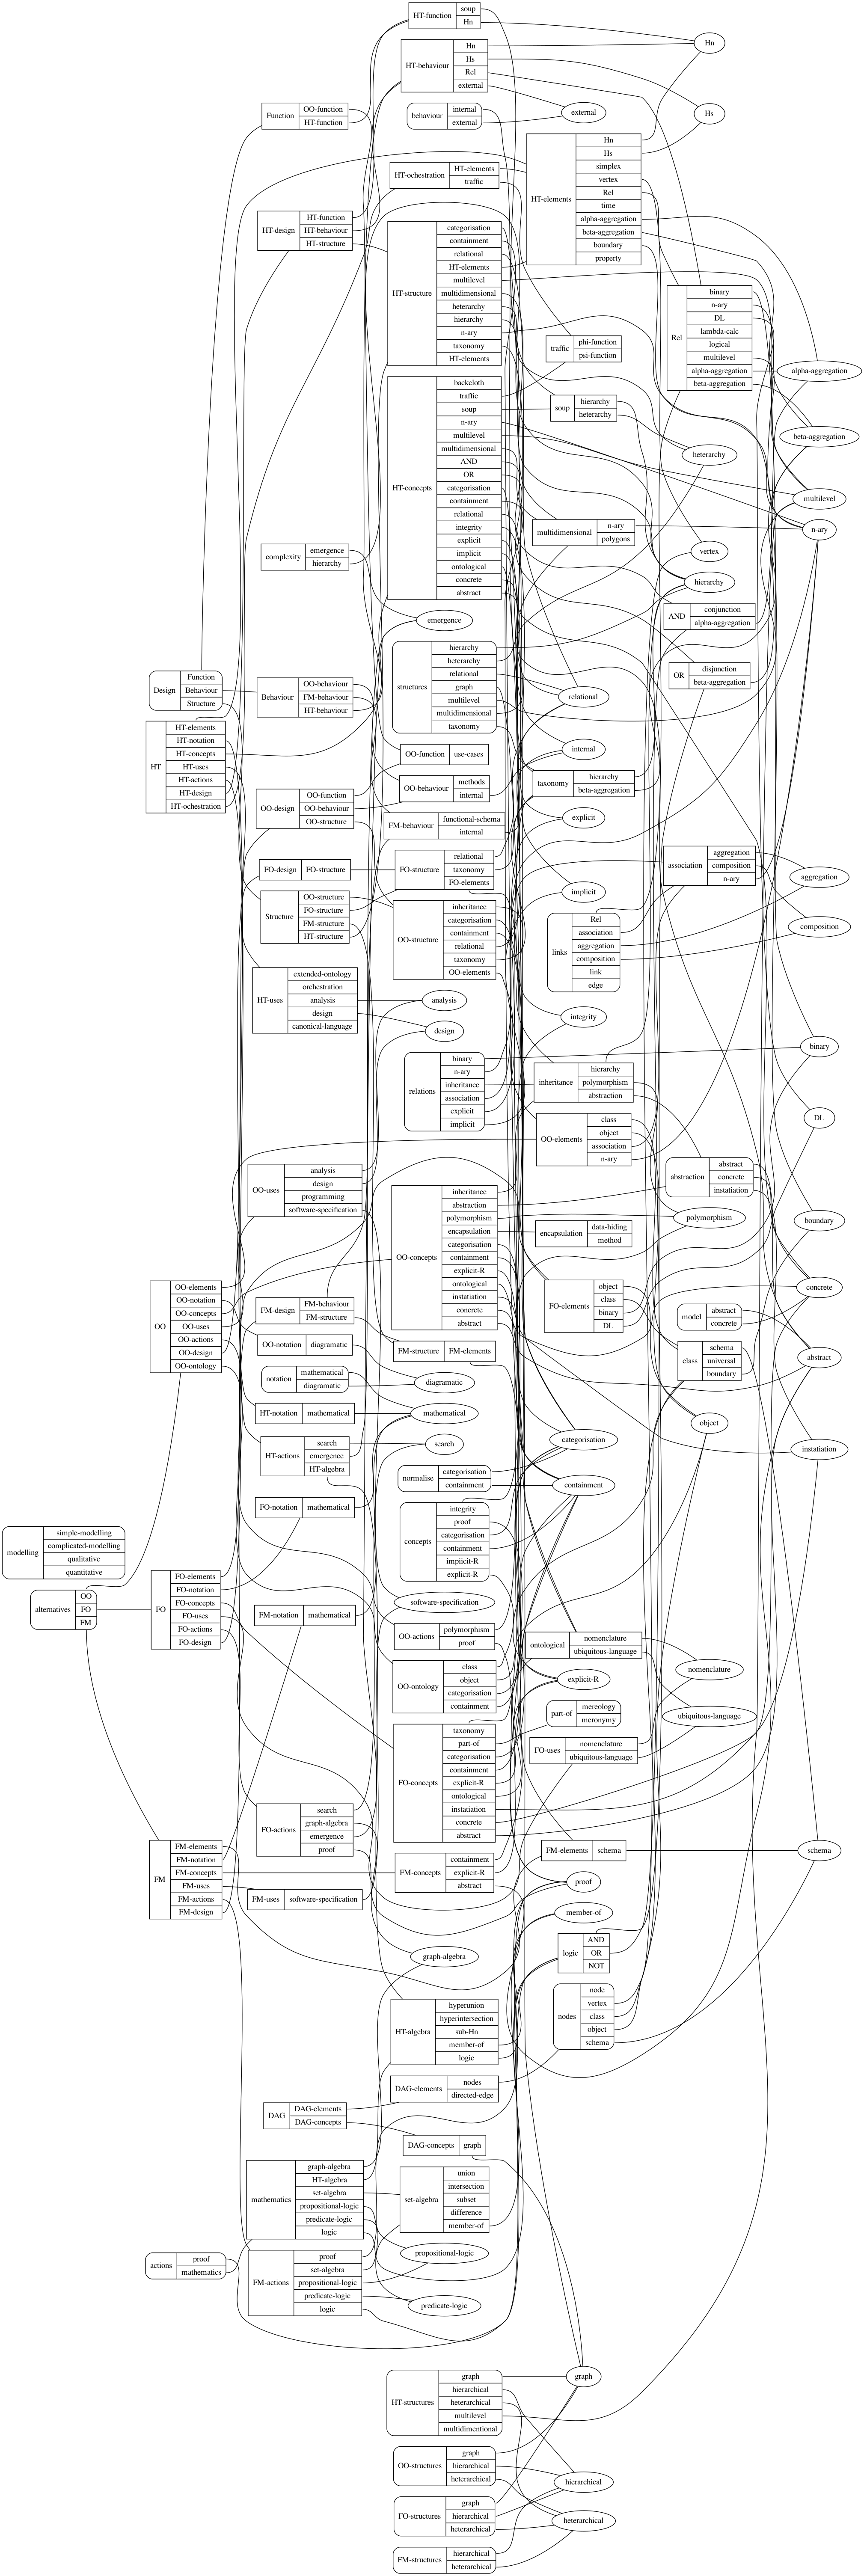

In [10]:
function_hn = soup_to_hn(soup)
# print(function_hn)

draw_hn_image(function_hn, "pictures/Thesis-function-hn", 1200, 1200, suppress=True, show_boundary=False, show_vertex=False)

What we have now is a full description of the Thesis *system*.  The soup has not constrained the structure, meaning that in FBS design terms we have the *Function*.  It is simply a multilevel, multidimentional backcloth with boundaries embeded.  The Hora function that takes the transformed soup, creates this model without human intervention.  Things are allocated to boundaries automatically, and possibly to more than one.  

### Boundaries

In [11]:
print(get_boundaries(function_hn))

['Model', 'Function', 'Ontology', 'Complexity', 'Structure', 'Notation', 'OO', 'FO', 'HT', 'Orchestration', 'Actions', 'Canonical-Language', 'FM', 'Behaviour', 'Design']


## Expected Behaviour (Be)

The Expected Behaviour of the Thesis *system* is interpreted as "*how the Thesis will say what it needs to say*".

The next step is to find the alternatives to the narrative of the Thesis.  As with many designs there are a number of different ways in which the *Thesis will say what it needs to say*.  What follows are three options, each with a set of *Be*'s that can be compared, selected, and a structure defined.  Ee use standard Hora functionality to select boundaries and merge results to find the topics that should be covered and compared by each option.

### Option 1
Direct comparison of HT vs. OO, HT vs. FO, and HT vs. FM.  These comparisions will simply merge HT with each alternative in turn, thus higlighting their differnces and similarites.

To create each comparison we can get the Sub-Hn's by Boundary, one for the HT and one for the alternatives.  These are then unioned with the result as a Hn that shows the conjuntion and disjoint of the two descriptions.  The result is a Hn that covers all aspects of the languages being compared, using this will allow us to write about these comparisons, what does one have that the other does not, or what do they share, and how well each language performs.

#### Compare HT with OO

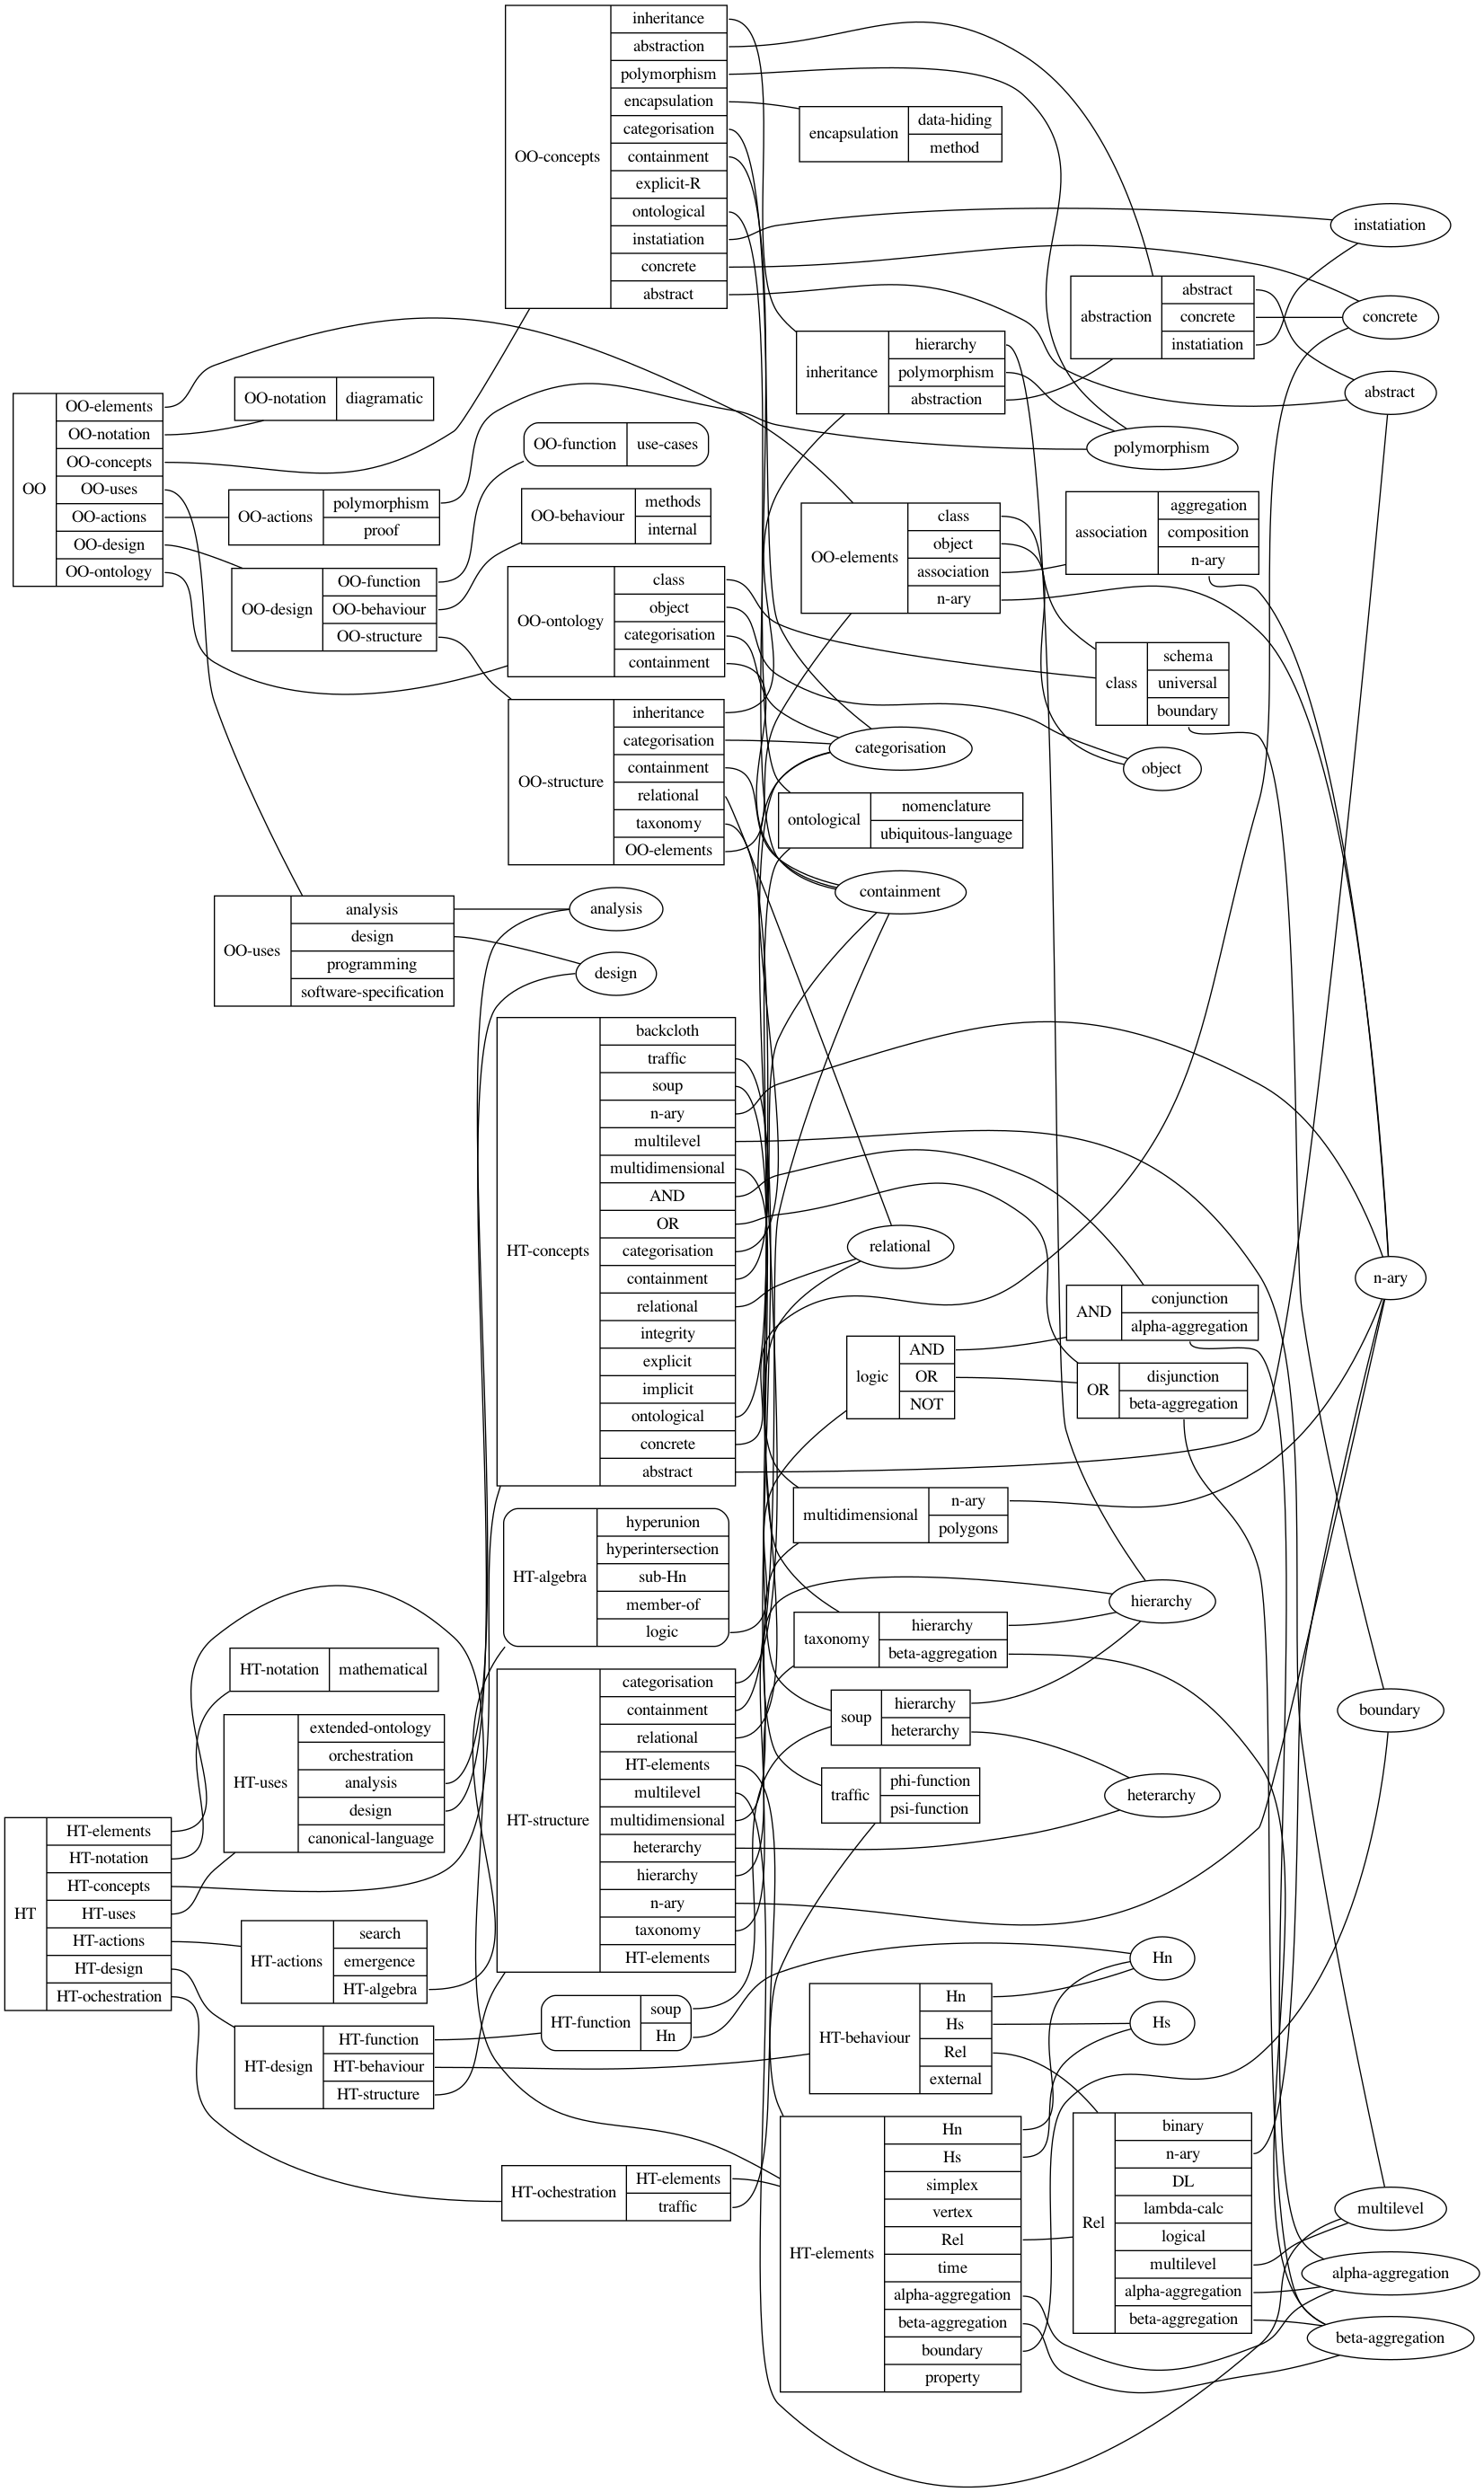

In [12]:
Hn = Hypernetwork()

tempHn = Hypernetwork()
Hn.union(get_subHn_by_semantic_boundary(function_hn, "HT", tempHn))
tempHn = Hypernetwork()
Hn.union(get_subHn_by_semantic_boundary(function_hn, "OO", tempHn))

draw_hn_image(Hn, "pictures/Thesis-HT-OO-1-behaviour-hn", 1000, 1000, suppress=True, show_boundary=False, show_vertex=False)

#### Compare HT with FO

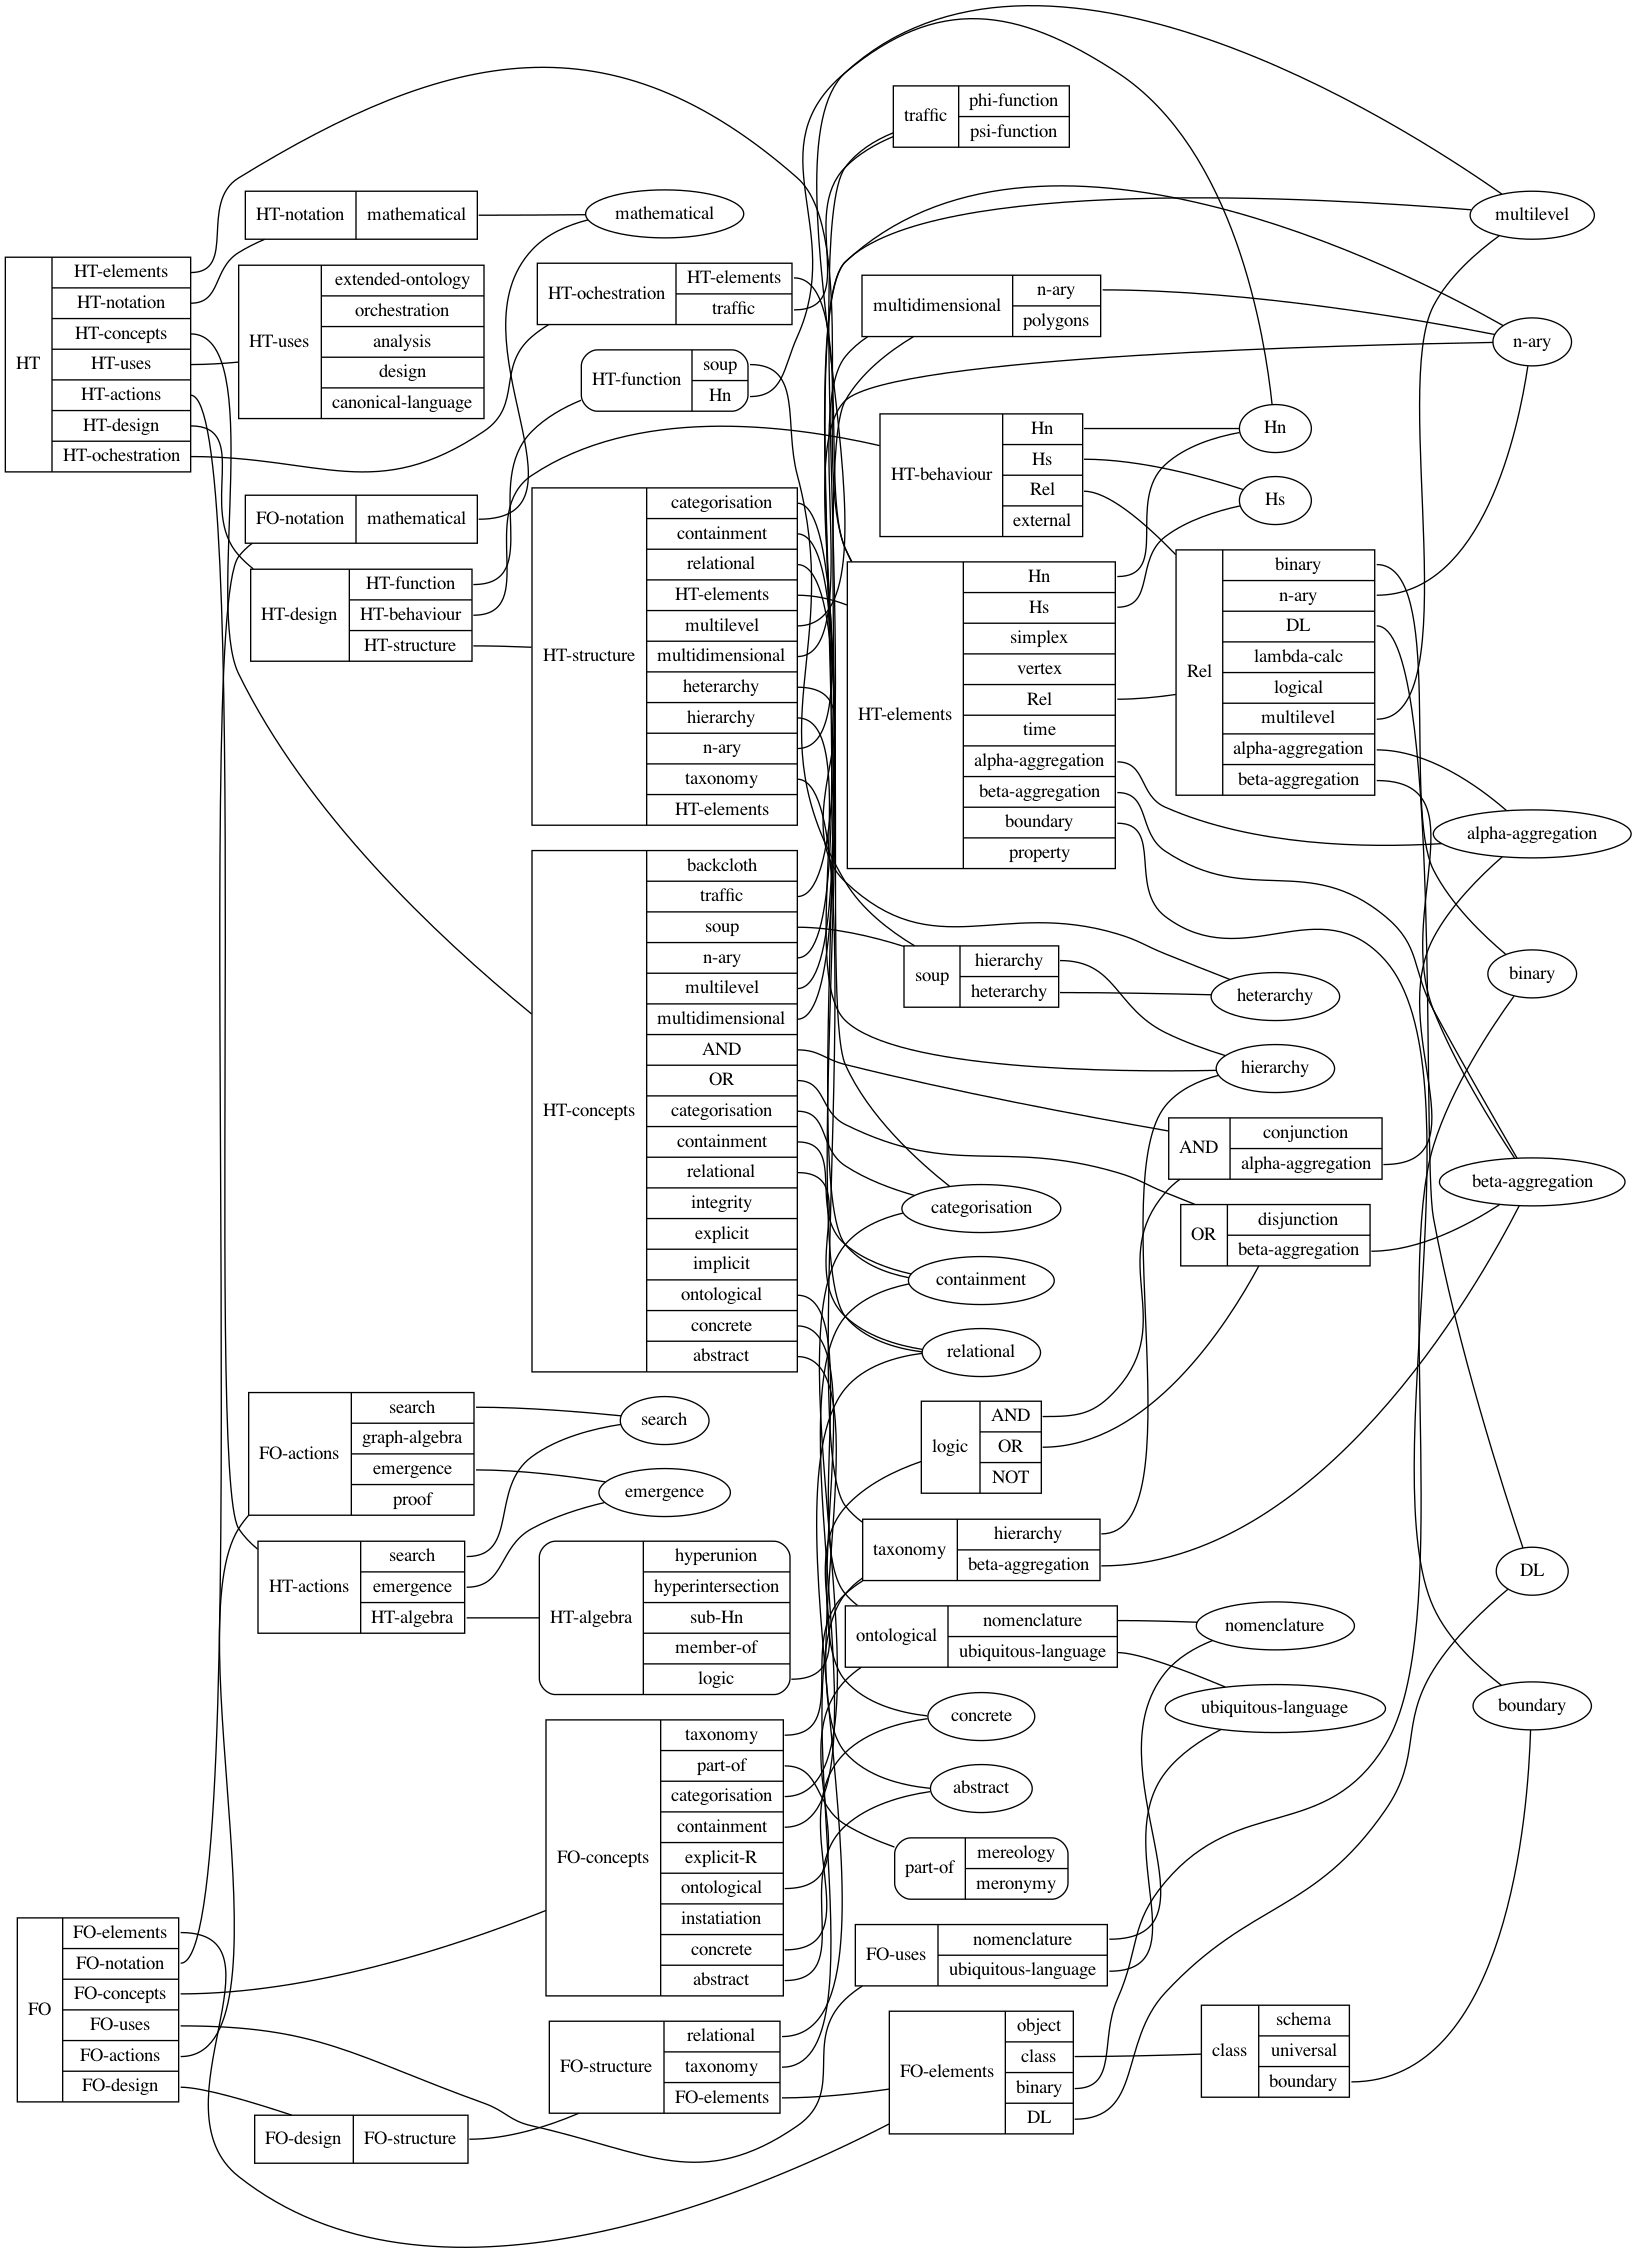

In [13]:
Hn = Hypernetwork()

tempHn = Hypernetwork()
Hn.union(get_subHn_by_semantic_boundary(function_hn, "HT", tempHn))
tempHn = Hypernetwork()
Hn.union(get_subHn_by_semantic_boundary(function_hn, "FO", tempHn))

draw_hn_image(Hn, "pictures/Thesis-HT-FO-1-behaviour-hn", 1000, 1000, suppress=True, show_boundary=False, show_vertex=False)

#### Compare HT with FM

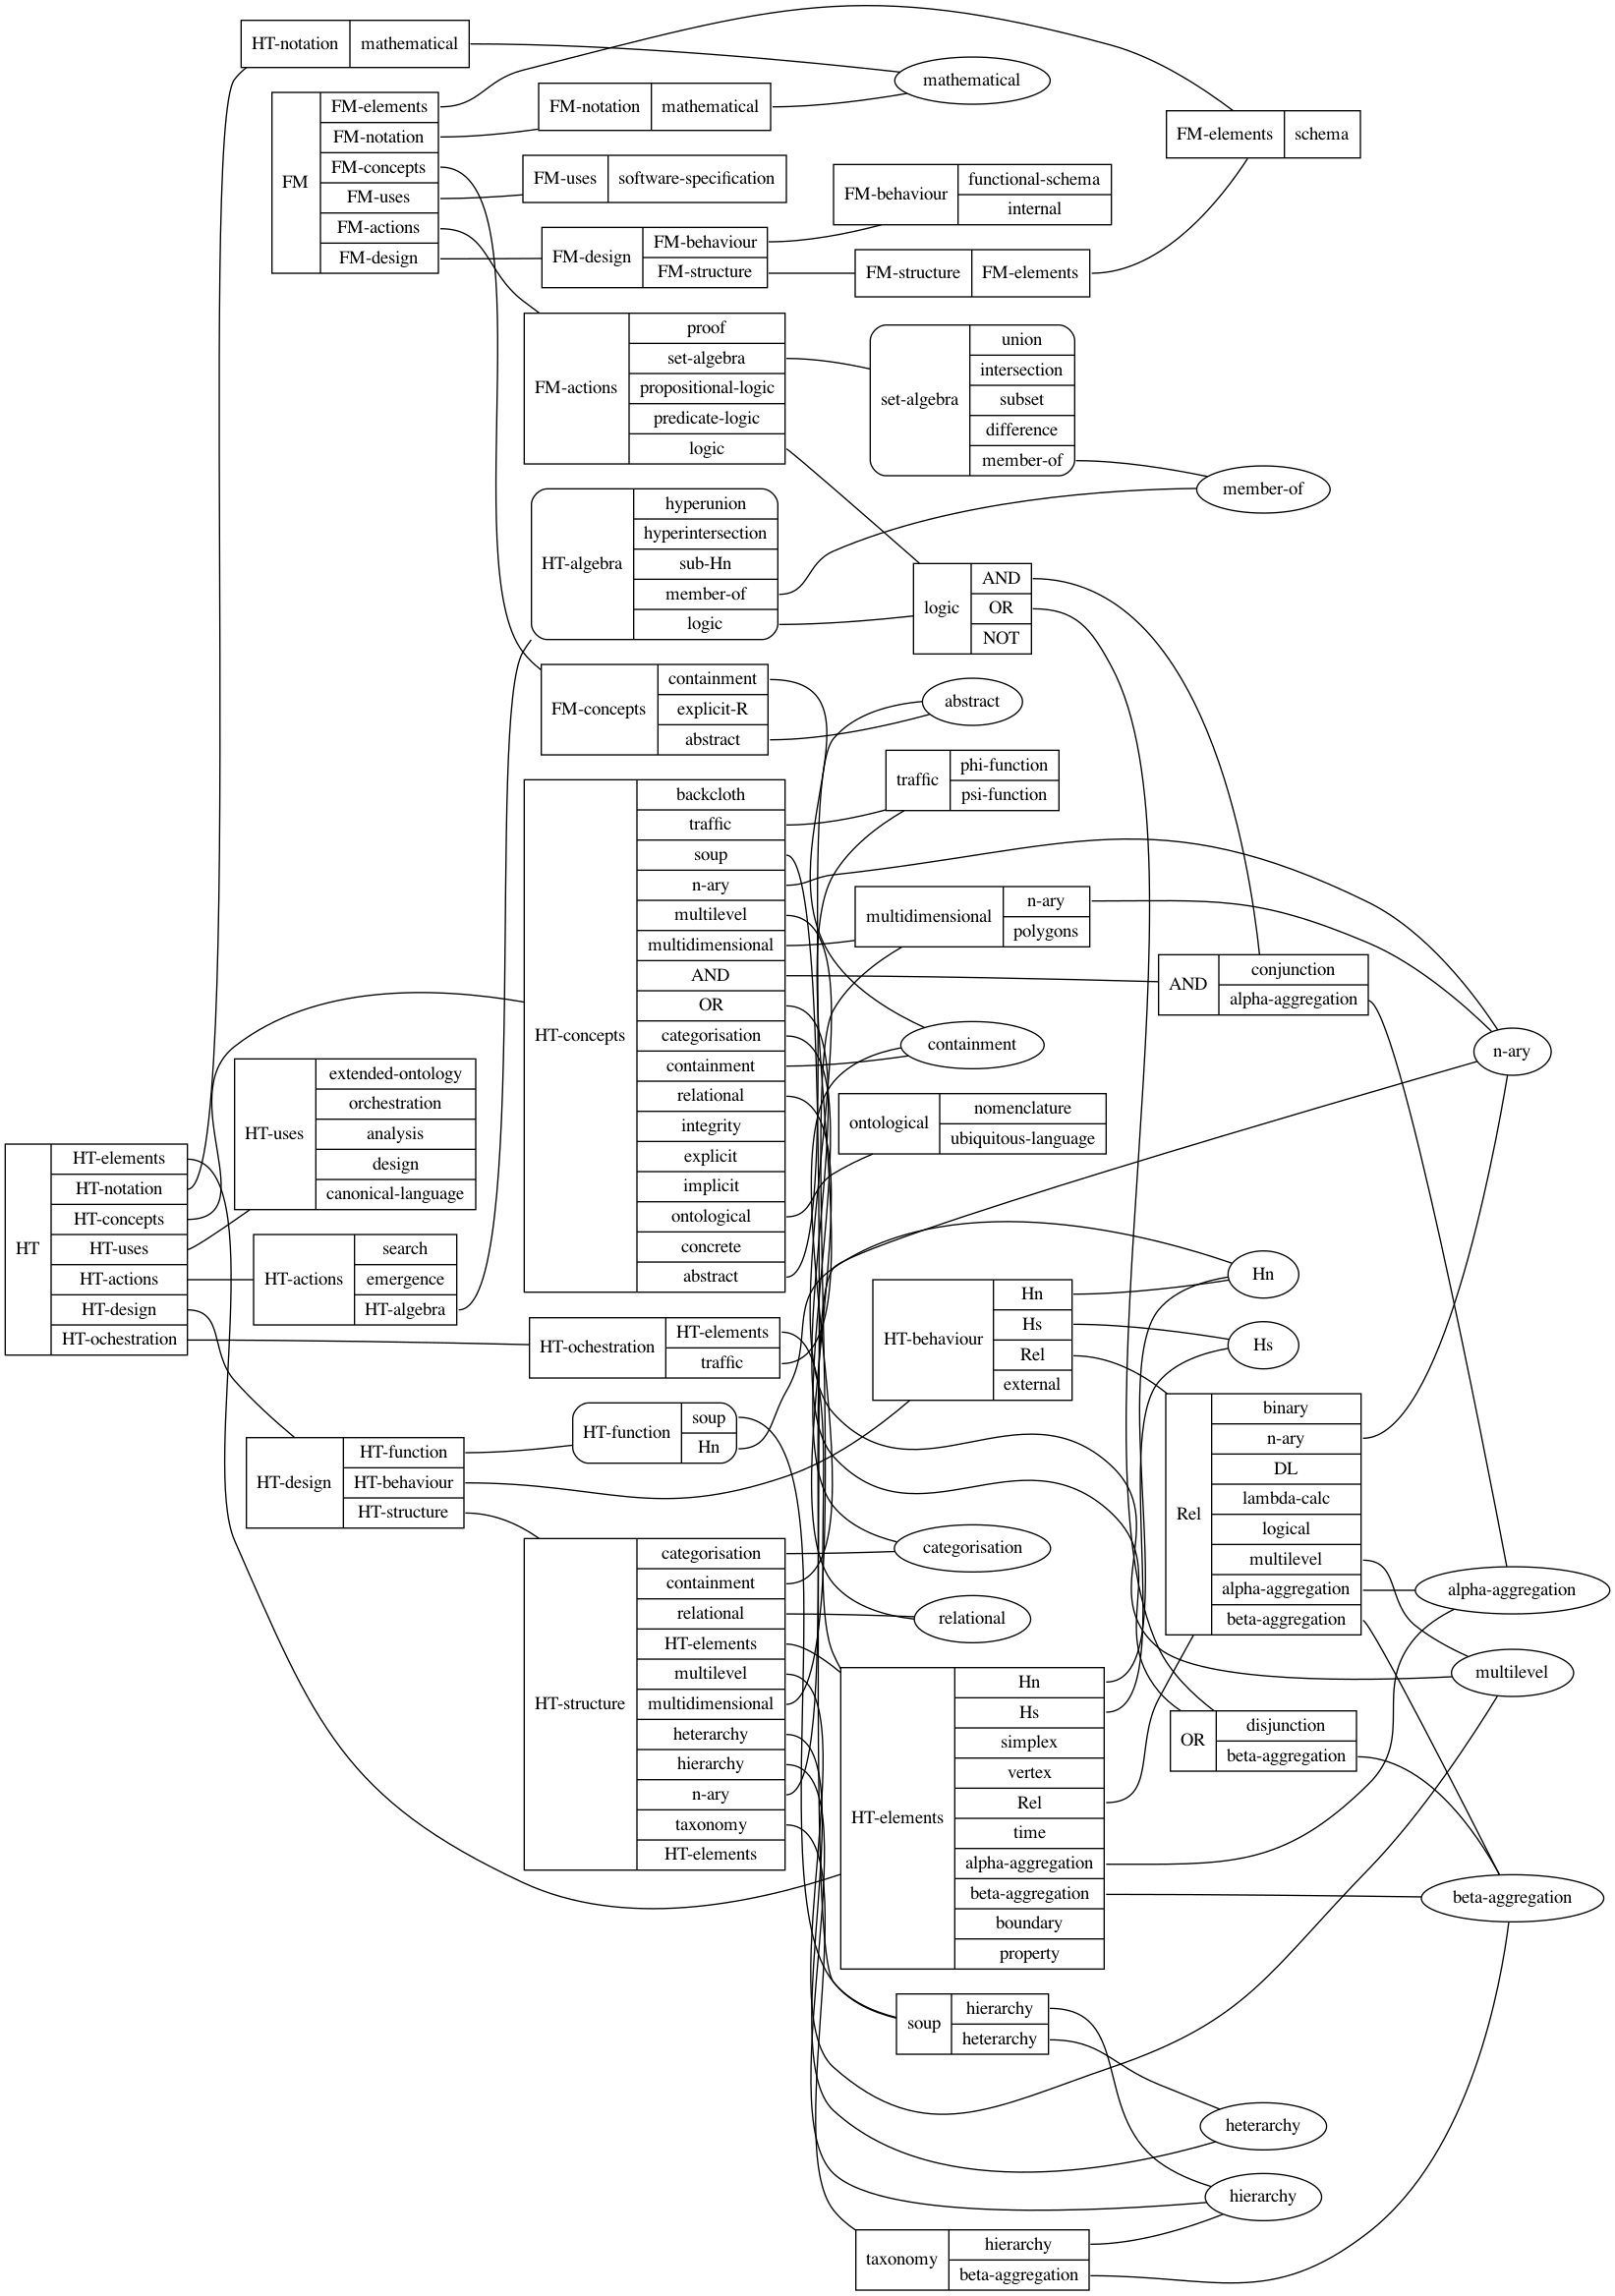

In [14]:
Hn = Hypernetwork()

tempHn = Hypernetwork()
tempHn = get_subHn_by_semantic_boundary(function_hn, "HT", tempHn)
Hn.copy(tempHn)
tempHn = Hypernetwork()
tempHn = get_subHn_by_semantic_boundary(function_hn, "FM", tempHn)
Hn.union(tempHn)

draw_hn_image(Hn, "pictures/Thesis-HT-FM-1-behaviour-hn", 1000, 1000, suppress=True, show_boundary=False, show_vertex=False)

### Option 2
Use a set of aspects of models and/or design, for example, relations, structure, behaviour and actions, and discuss how each aspect would be satisfied, or not, by each language.  This would provide an orthogonal comparison of each of these to identify the deficiencies, similarities etc.  The advantage of this approach is that it is othogonal and allows us to compare across each language without repretition.

#### Function

What are the comparative elements of each language in relation to *Function*?

Function Boundaries: {'Design', 'Function'}
|-- OO-function Boundaries: {'Function', 'Design', 'OO'}
|-- |-- use-cases Boundaries: {'Function', 'Design', 'OO'}
|-- HT-function Boundaries: {'Function', 'Design', 'HT'}
|-- |-- soup Boundaries: {'Model', 'Function', 'Structure', 'HT', 'Design'}
|-- |-- |-- hierarchy Boundaries: {'Model', 'Function', 'Ontology', 'Complexity', 'Structure', 'OO', 'HT', 'Canonical-Language', 'Design'}
|-- |-- |-- heterarchy Boundaries: {'Function', 'Ontology', 'Structure', 'HT', 'Canonical-Language', 'Model', 'Design'}
|-- |-- Hn Boundaries: {'Function', 'Ontology', 'Structure', 'HT', 'Canonical-Language', 'Behaviour', 'Design'}



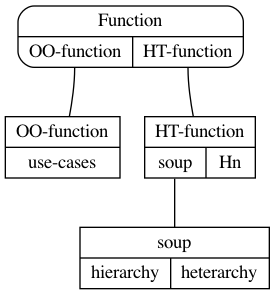

In [15]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Function", subHn)

output_hierarchy(subHn)

draw_hn_image(subHn, "pictures/Thesis-func-2-function-hn", 200, 1000, direction="NS", suppress=True, show_boundary=False, show_vertex=False)

This model illustrates, that actually the methods are limited in their support for *Function*.  This is likely because FO does not cover function, it only covers structure, and FM is a language for behaviour, and to a limited extent structural.

Based on this comparision having a dedicated chapter would probably be overkill.  The narrative to the *Function* would look something like this, note this is only given as a sample and will not be provided for the other options:

"Of the modelling languages we are looking at only OO and HT capture the FBS *function* of a system.  OO, specifically UML, uses *Use Case* diagrams to capture the relation between functions and Use Case definitions to describe the individual Use Case -- remember the Use Case is the individual node on the diagram not the diagram itself.  However, classes and objects do not form part of FBS Functions, they come later when we look at Structure.  And as we are only interested in *classes* and *objects* as part of this Thesis, this description is technically redundant.

As with everything in HT we use the *Hierarchical Soup*, or *Heterarchical Soup*, from which we can extract the Hn, as has been used here.  Although not part of HT, there is nothing stopping us using Use Cases as an additonal approach to capturing Function and using this as input into a transformation to Hn.  In fact there is no reason that the UC diagram could not be modelled as a Hn.  Each Use Case would be defined in the normal way with UML, but the diagram could have the [TBC] as shown below.

HT is not a diagrammatic language, but it is a *canonical language* and can be used to capture models for many different diagrams, then using diagramming tools, such as Graphviz [ref] and a simple program, the diagrams can be generated."  [would be good to generate the diagram below]

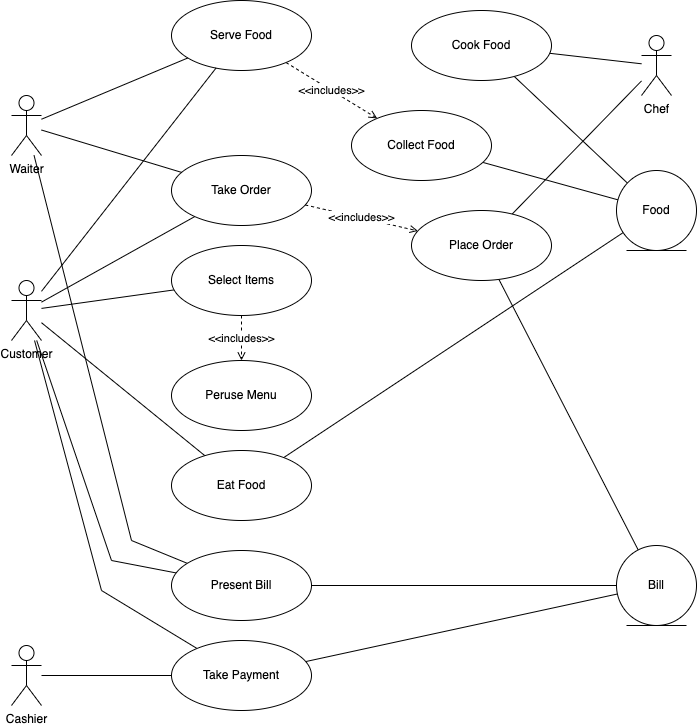

In [16]:
Image(filename="Thesis-examples-UseCaseExample.drawio.png", width=500, height=500)

In [17]:
use_case_hn = Hypernetwork()

compile_hn(use_case_hn, parser, """
    
""")

# draw_hn(use_case_hn, fname="pictures/UseCase-Example-Function", view=False, split_camel=False)
# Image(filename="pictures/UseCase-Example-Function.png", width=800, height=800)

#### Behaviour

What are the comparative elements of each language in relation to *Behaviour*?

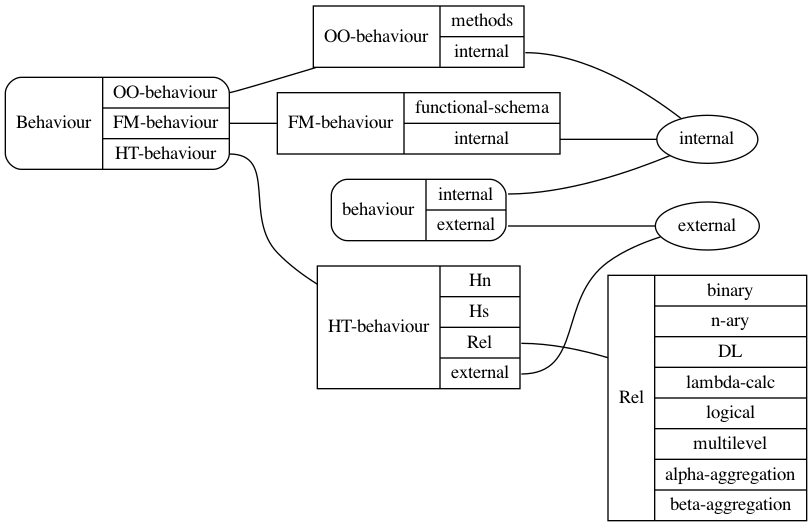

In [18]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Behaviour", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-2-behaviour-hn", 700, 1200, direction="LR", suppress=True, show_boundary=False, show_vertex=False)

#### Structure

What are the comparative elements of each language in relation to *Structure*?

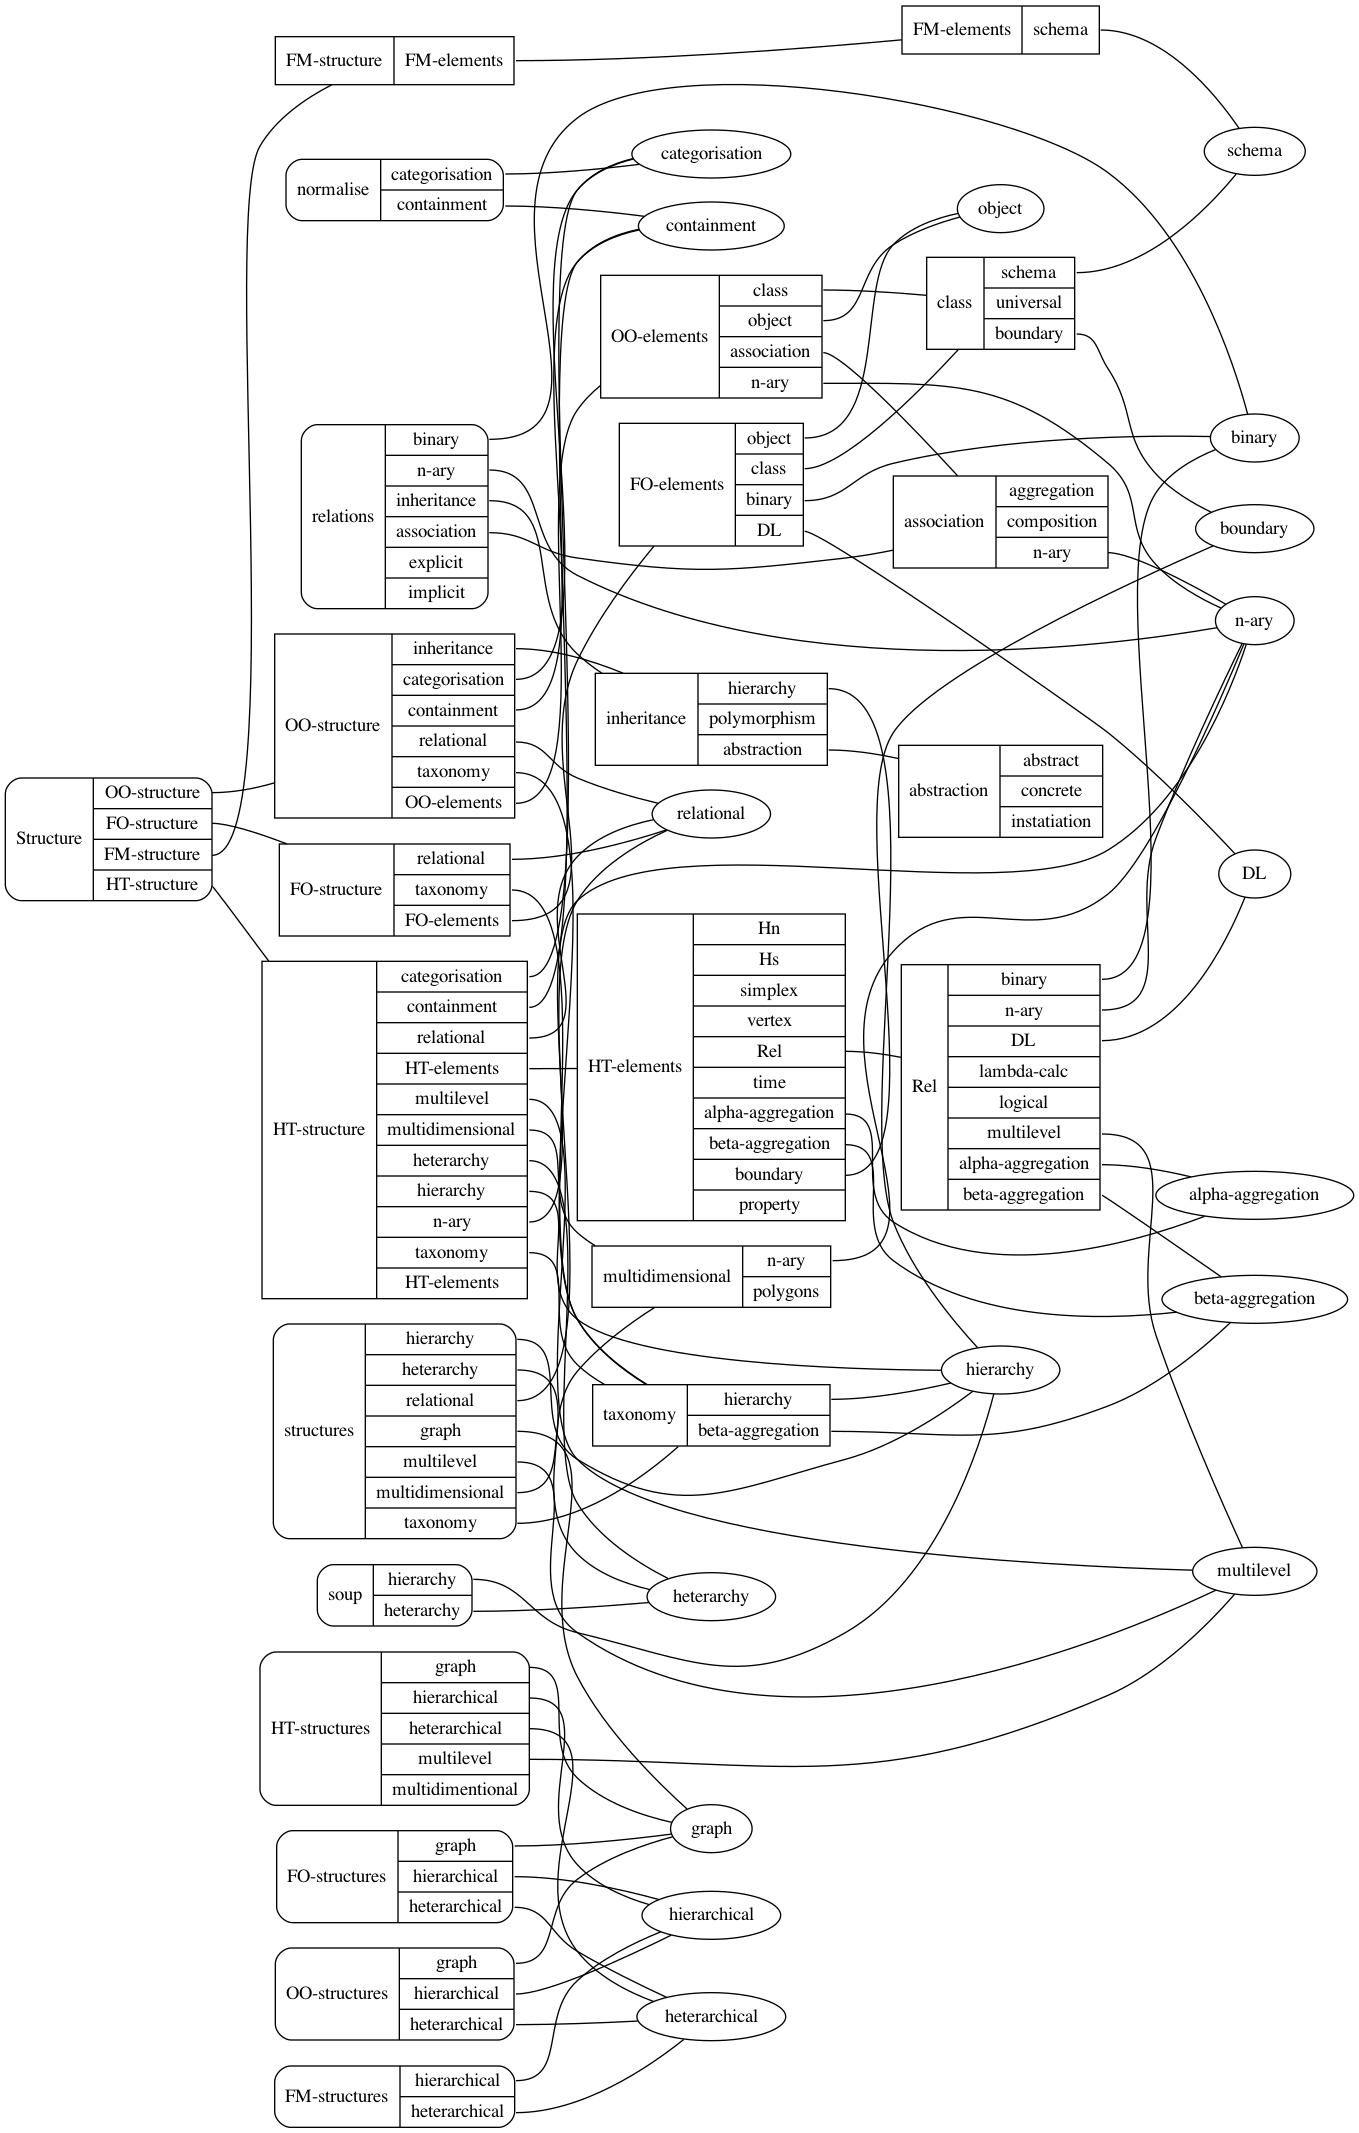

In [19]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Structure", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-2-structure-hn", 1000, 1000, suppress=True, show_boundary=False, show_vertex=False)

*Structure* has the most elements, which is expected as all methods have structure.

#### Actions

What actions can be performed on the model?

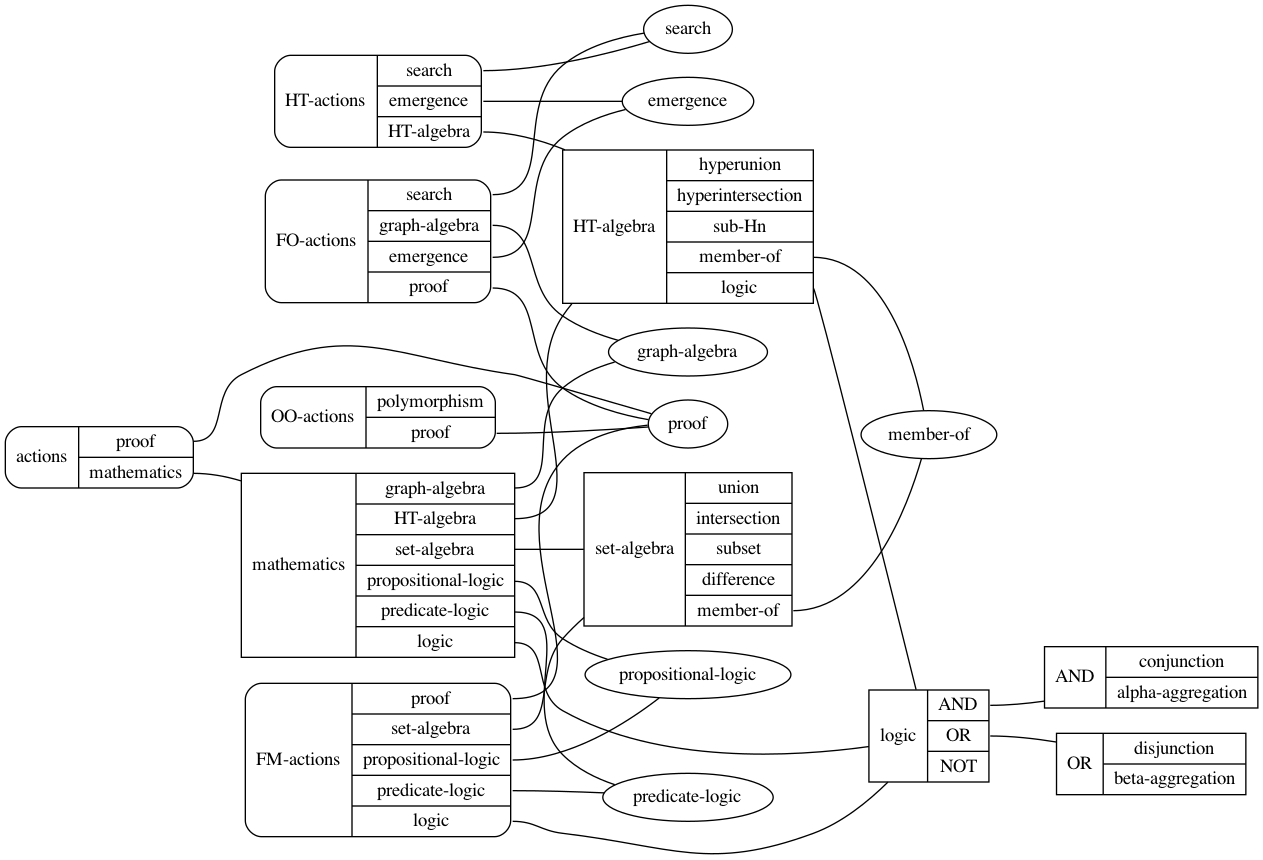

In [20]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Actions", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-2-actions-hn", 900, 800, suppress=True, show_boundary=False, show_vertex=False)

#### Deficiencies

Each of these modelling languages has its deficiencies, this model illustrates these.

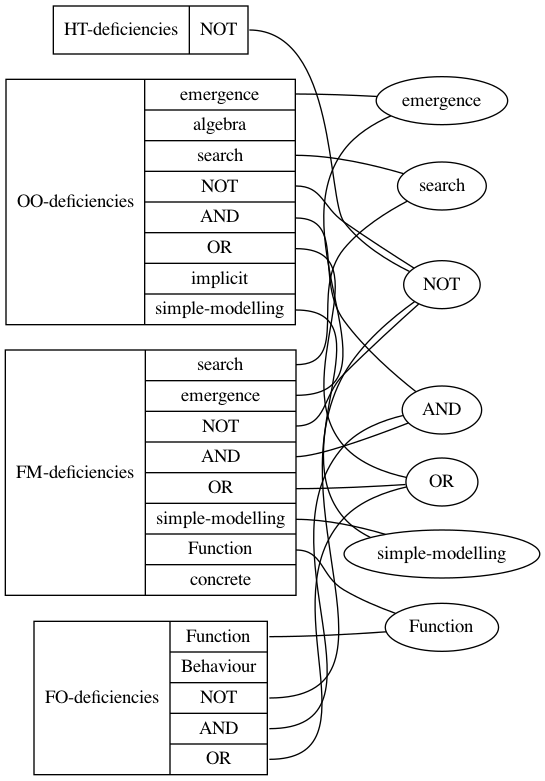

In [21]:
subHn = Hypernetwork()

compile_hn(subHn, parser, """
	OO-deficiencies=<emergence, algebra, search, NOT, AND, OR, implicit, simple-modelling; B(Deficiencies)>
	FM-deficiencies=<search, emergence, NOT, AND, OR, simple-modelling, Function, concrete; B(Deficiencies)>
	FO-deficiencies=<Function, Behaviour, NOT, AND, OR; B(Deficiencies)>
    HT-deficiencies=<NOT; B(Deficiencies)>
""")

# subHn = get_subHn_by_semantic_boundary(subHn, "Deficiencies", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-2-deficiencies-hn", 400, 400, direction="LR", suppress=True, show_boundary=False, show_vertex=False)

Note: with this model of the Deficiencies we have created a new Hn just for this purpose.  The reason is two-fold, 1) (ironically) HT does not currently support NOT, so we cannot express that we do not want some form of negation in the model so that some Hs are highlighted as not wanted; and 2) there is currently no Boundary Algebra which could be used to exclude unwanted Hs from the model.  Until this point both the lack of NOT and Boundary Algebra were not even considered necessary, but this exercise has highlighted a potential need for this in the future.

### Option 3
Take each identified Use Case for HT and demonstrate how the alternatives would satisfy that use case by providing an example of each.  The discussion would take each sub-Hn provided below and describe what each topic means in relation to the use case.  This would form a comparitive narrative for the example, illustrating the potential in the alternitves to HT for that given use case.

#### Design

It is the design of this Thesis that is given as the design example.

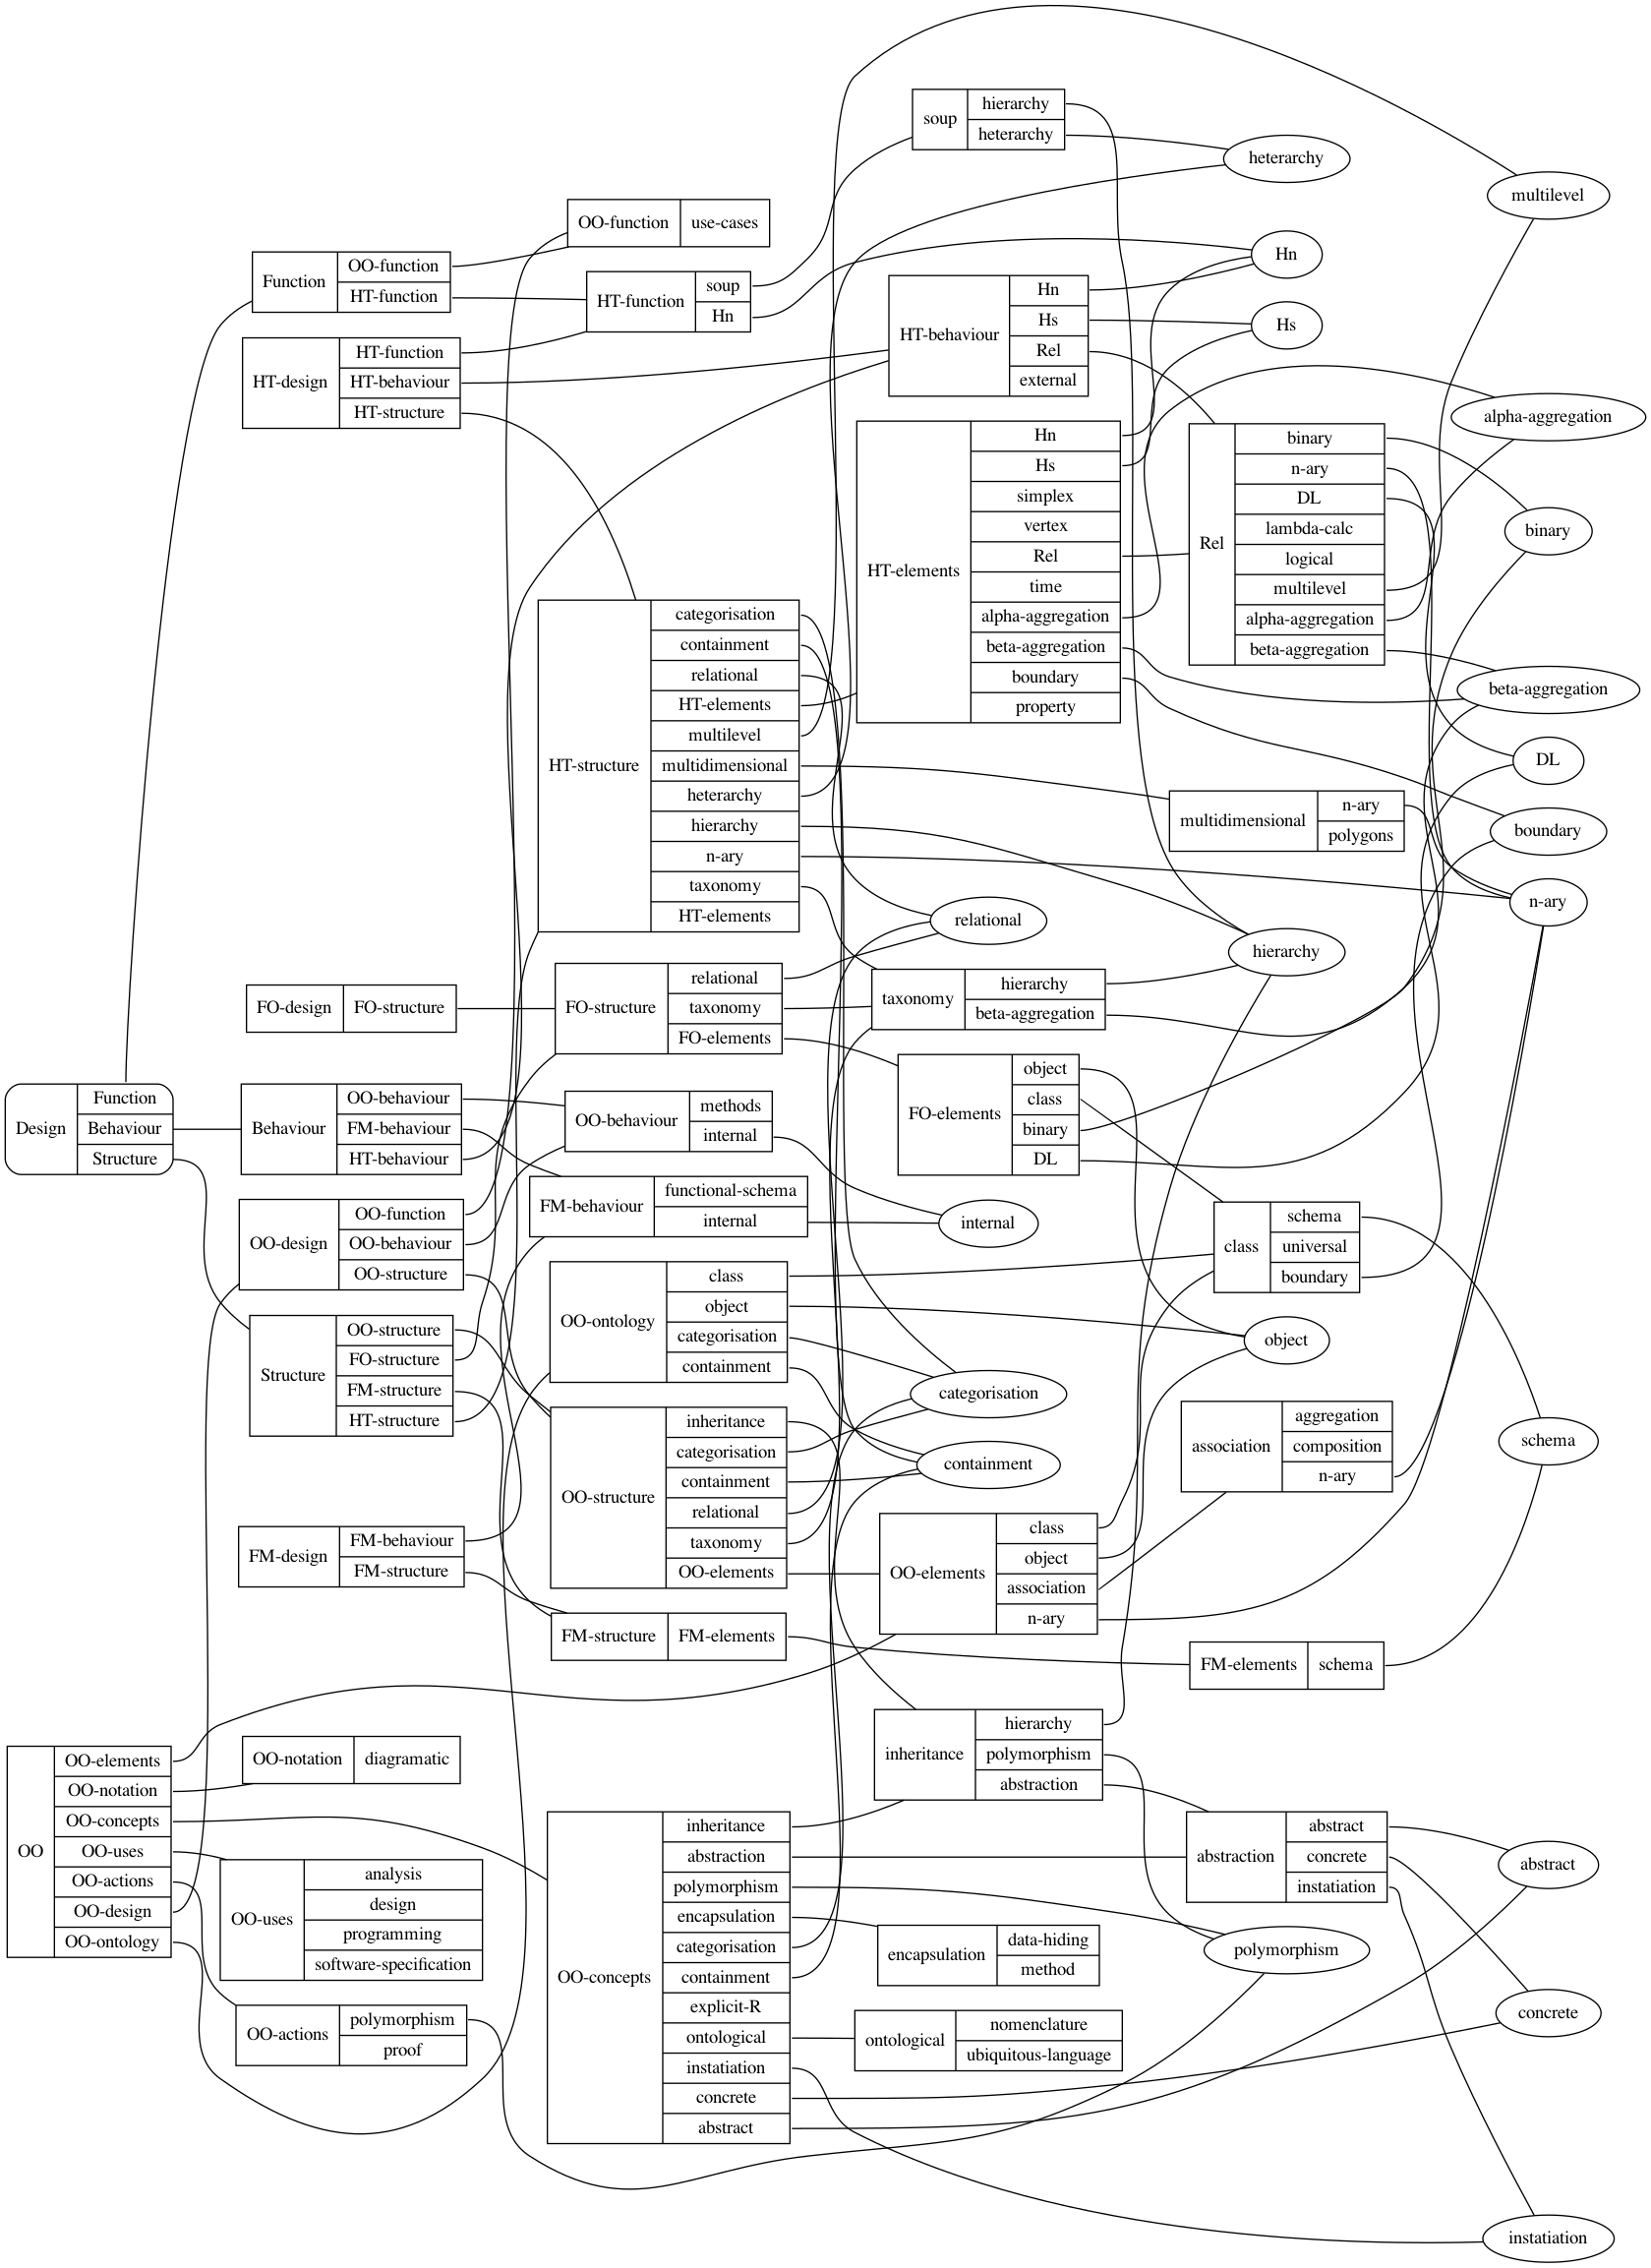

In [22]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Design", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-3-design-hn", 1200, 1000, suppress=True, show_boundary=False, show_vertex=False)

#### Ontology

The example for *Ontology* is MEDA.

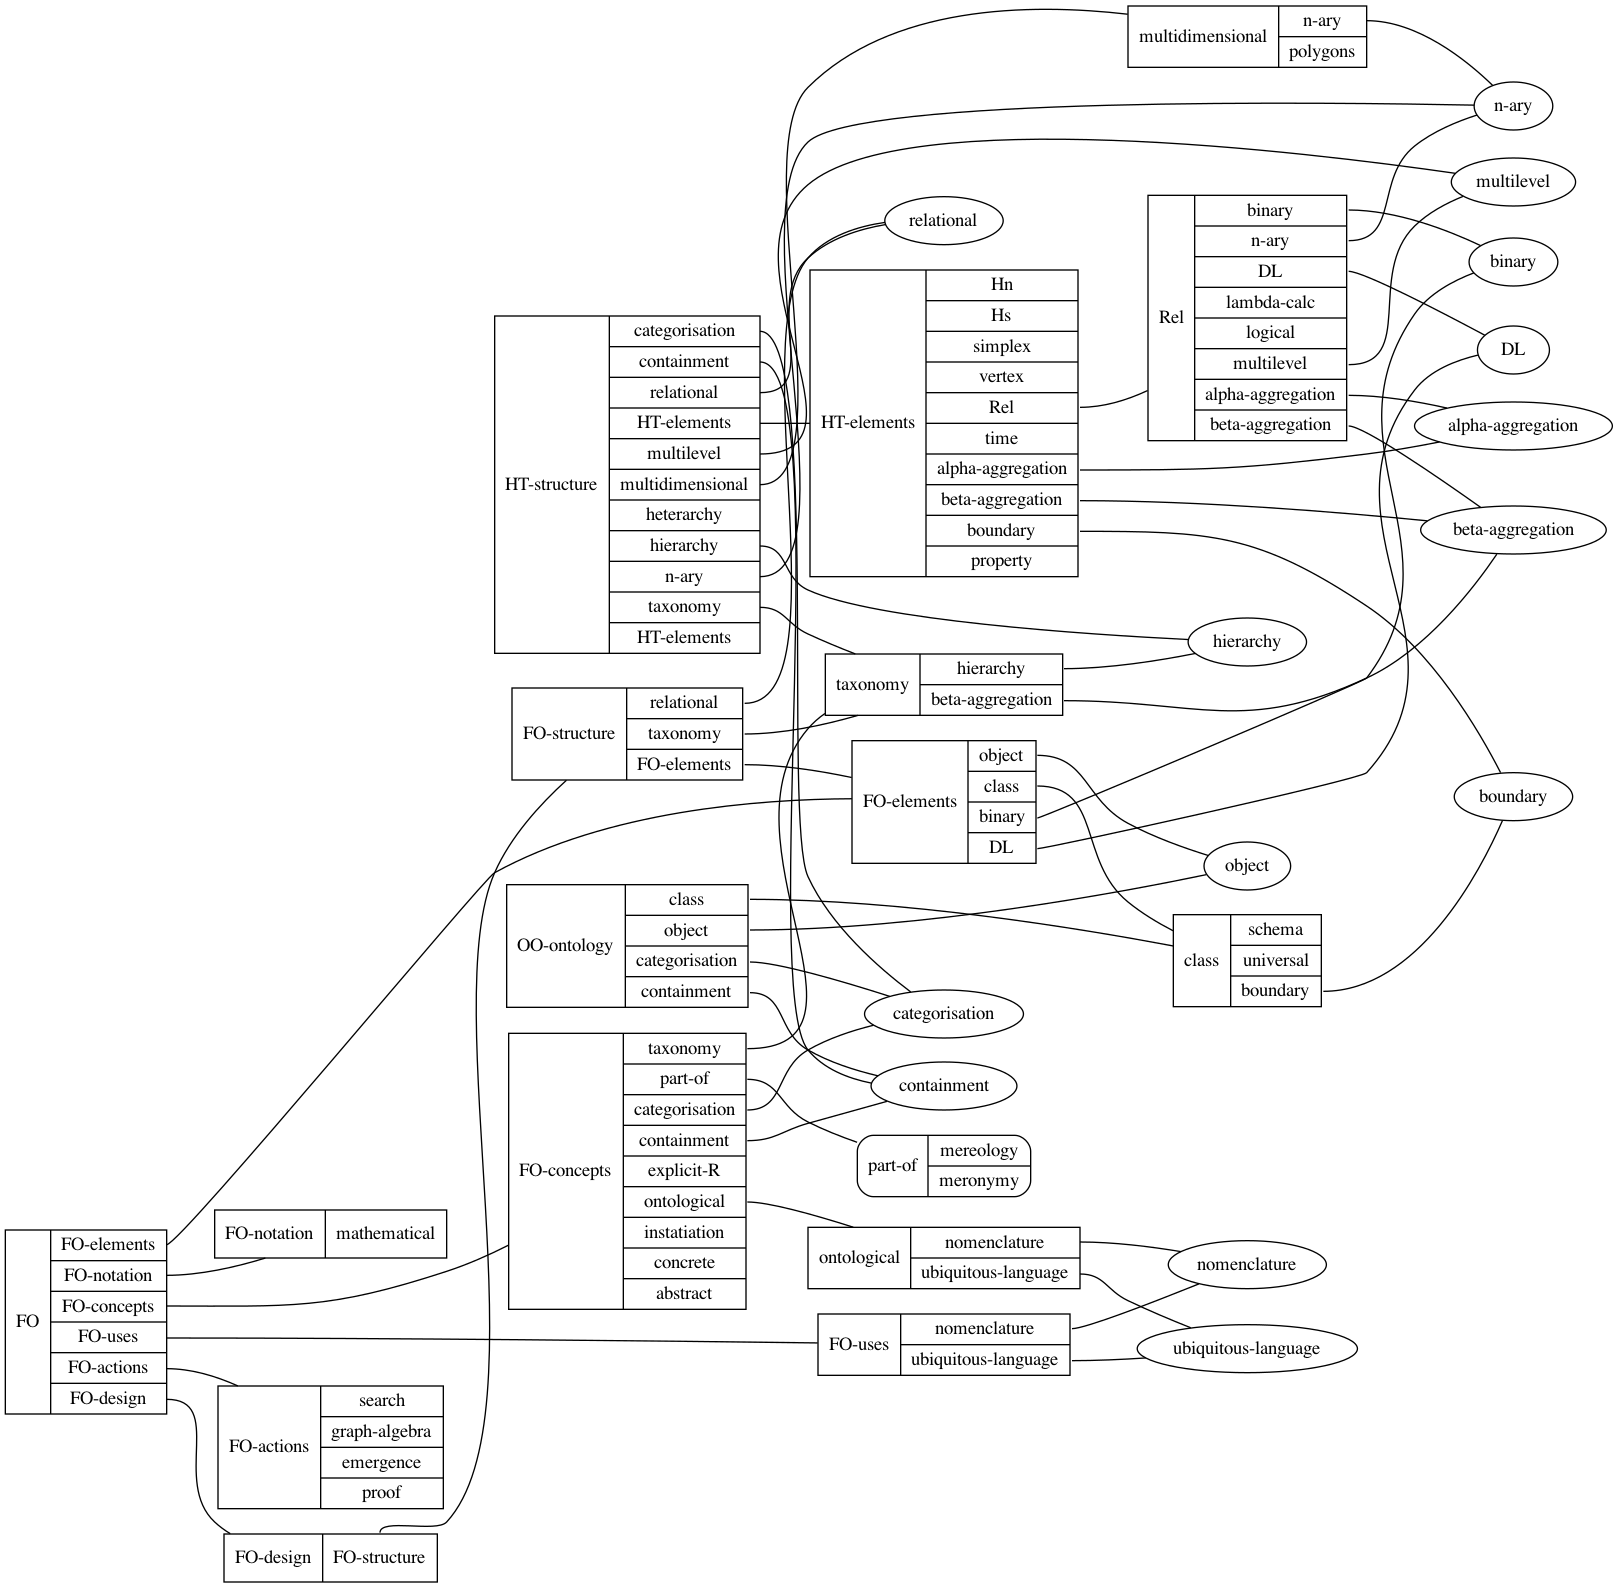

In [23]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Ontology", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-3-ontology-hn", 1000, 1000, suppress=True, show_boundary=False, show_vertex=False)

#### Canonical Language

For *Canonical Language* we would use the *HyperPn* or *4C* examples to demonstrate this use case.

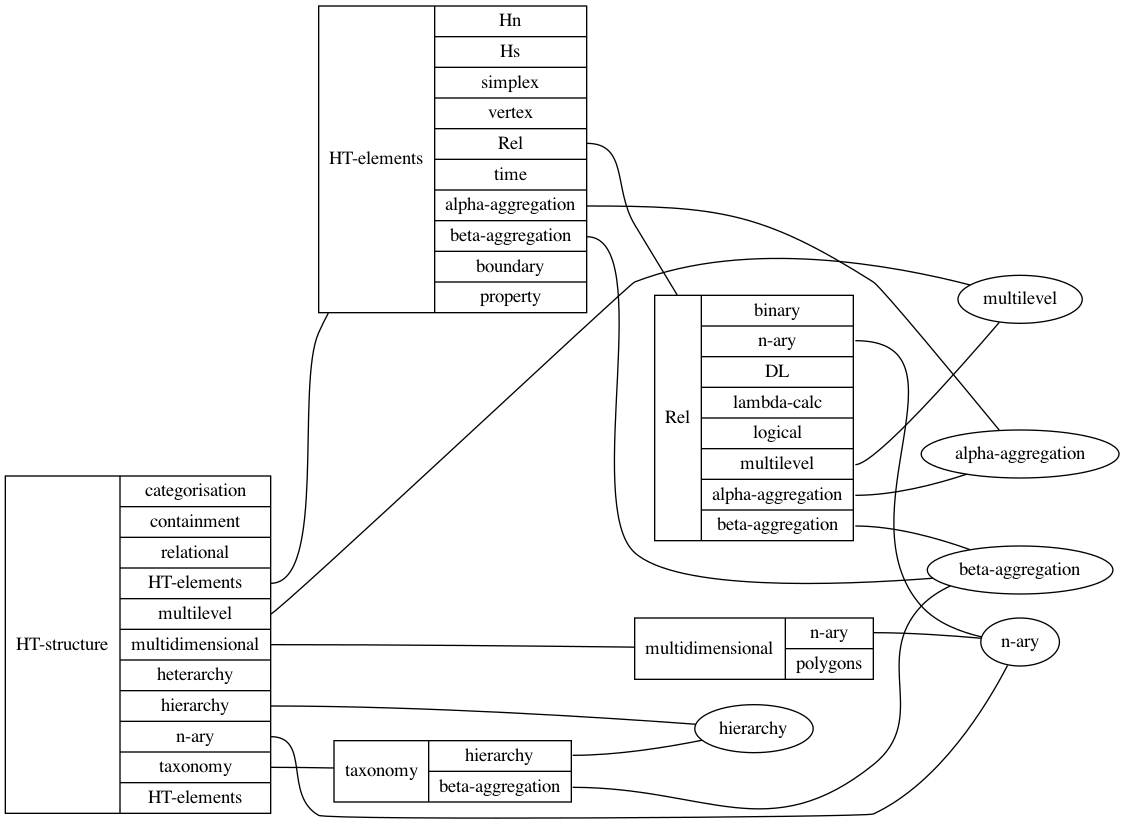

In [24]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Canonical-Language", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-3-canonical-hn", 800, 1000, suppress=True, show_boundary=False, show_vertex=False)

#### Orchestratation

We would use SEMS are the example for demonstrating the *Orchestration* use cases.

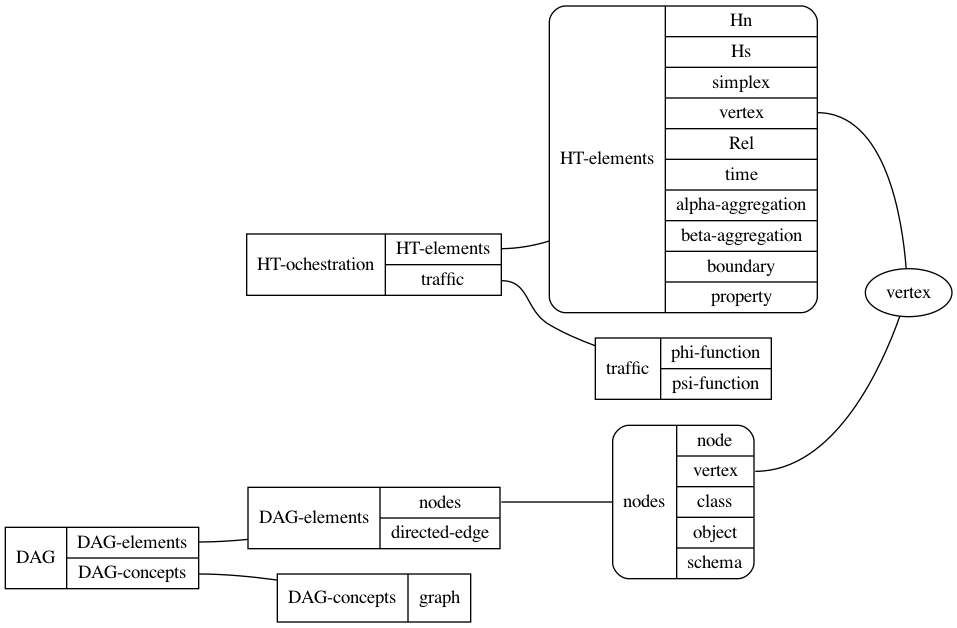

In [25]:
subHn = Hypernetwork()
subHn = get_subHn_by_semantic_boundary(function_hn, "Orchestration", subHn)

draw_hn_image(subHn, "pictures/Thesis-func-3-orchestration-hn", 700, 1000, suppress=True, show_boundary=False, show_vertex=False)

# Structure (S)

In [26]:
def get_topic(hn, topic):
    new_hn = Hypernetwork()
    
    def _get_subtopics(subtopic):
        for name in hn.hypernetwork[subtopic].simplex:
            hs = hn.hypernetwork[name]
            new_hn.insert_hs(name, hs)
            
            for whole in hs.partOf:
                whole_hs = hn.hypernetwork[whole]
                new_hn.insert_hs(whole, whole_hs)

            _get_subtopics(name)

    hs = hn.hypernetwork[topic]
    new_hn.insert_hs(topic, hs)
    _get_subtopics(topic)
    
    return new_hn

In [27]:
def build_section(hn, headings):
    headings_hn = Hypernetwork()
    compile_hn(headings_hn, parser, headings)

    for topic, heading_hs in headings_hn.hypernetwork.items():
        if heading_hs.hstype in [VERTEX]:
            topic_hn = Hypernetwork()
            topic_hn = get_topic(hn, topic)
            hn.insert(vertex=topic, hstype=ALPHA, simplex=get_peaks(topic_hn), B=heading_hs.B, N=heading_hs.N)
            
        else:
            hn.insert(vertex=topic, hstype=ALPHA, simplex=heading_hs.simplex, B=heading_hs.B, N=heading_hs.N)
    
    return hn

In [28]:
structure_hn = Hypernetwork()
structure_hn = get_subHn_by_semantic_boundary(function_hn, "Structure", structure_hn)

temp_hn.copy(structure_hn)

# temp_hn = get_topic(structure_hn, "structures")
# print(temp_hn)
# build_section(temp_hn, """
compile_hn(temp_hn, parser, """
    sec-structure=<sub-structures, relations>^N(2)
    sub-structures=<taxonomy, inheritance>^N(1)
""")

# output_hierarchy(temp_hn)

draw_hn_image(temp_hn, "pictures/Thesis-struct-2-structures-hn", 800, 1000, suppress=True, show_levels=False, show_boundary=False, show_vertex=False)

NameError: name 'temp_hn' is not defined

In [ ]:
temp_hn = get_topic(structure_hn, "relations")
# compile_hn(structure_hn, parser, """    
# "")

draw_hn_image(temp_hn, "pictures/Thesis-struct-2-relations-hn", 700, 1000, suppress=True, show_boundary=False, show_vertex=False)

In [ ]:
temp_hn = get_topic(structure_hn, "taxonomy")
# compile_hn(structure_hn, parser, """    
# "")

draw_hn_image(temp_hn, "pictures/Thesis-struct-2-relations-hn", 800, 1000, suppress=True, show_boundary=False, show_vertex=False)

# HT vs. OO, FO and FM

The question is now *could we model the Thesis Design with OO, FM or FO, or with one of the structure languages described in chapter 2?*

With FM we could specify a software system to model this with FM, but you could not model the Thesis design itself.  FM is not suitable for capturing the *concrete* model.

With OO we could model an equivalent to the soup/Hn with an Object Diagram, as shown below.  In the diagram we show alternatives as 0:1 associations as there is no other equivelants of the $\beta$ in OO.  The issue with this is that we would need different diagrams for each scenario and that would be very time consuming and error prone.  Also, as diagrams they cannot be manipultated, combined and mathematically analysed.  To do this we would need a model.

In [ ]:
Image("Thesis-examples-ExampleOOFunction.drawio.png", width=400, height=400)

We can see there is a clear difference in the models in Options 1 and 3, and Option 2.  When compared to the models in options 2, the models in option 1 and 3 are much larger and more complicated.  This is because of two differences, firstly the option 1 models cover all aspects of function, behaviour and structure for HT and the alternatives, this means a lot of facts will be repeated on the side of HT.  Option 3 has a larger scope, however, even though the models include all aspects, it does not mean that these aspects are used in the use case examples, but they would be discussed nonetheless.  Secondly, in option 1 the selected boundaries cover all of HT and each alternative in turn, we have described some of this background in other chapters which means these could come out of this section.  However, for a comparison of these aspects they should really be included.

Option 2 models are, in comparison, much simpler.  They do not significantly repeat - there is a likelyhood that there will be some overlap as some methods appear in each, but as can be seen from the models this is minimal compared to option 1 models.  Option 2 models are also simpler than option 3.  Also with option 2 we can look at other aspects, for example the actions that can be performed on a modelling language.

Some of this may seem obvious, but this exercise illustrates the way in which different designs from the same initial set of relations can be extracted and compared with HT.  

The introduction of Boundaries to the standard HT makes this possible, or at least easier than developing a new algorithm for performing the search.  This was tried, it proved to be quite difficult to excluse the elements that were not relevant without altering the soup into a *contrived* form.  The use of boundaries resolved this issue and allowed standard sub-Hn functions to be used.

We could create a "Topic" class that references itself to form the hierarchy, of more specifically a directed graph.  We could add other reference, such as to itself as a parent, thus creating a bidirectional graph.  And, we could add other decorations to the class to allow for different interpretations.  We would need a way of capturing the values for each object in the Object Diagram and a way of populating the model.  Then we would have to develop functionality to interogate and manipulate the model.  The result would be a *custom* language and therefore nonstandard -- Hora was developed, in part, with OO.  The Hora library class model is shown below:

In [ ]:
Image("HoraClassDiagram.png", width=600, height=400)

Which creates a structure like this:

In [ ]:
Image("Thesis-HnDataModel.png", width=600, height=400)

The detail of this will be covered in Appendix A.  What this essentially gives us is an implementation of HT that allows any model to be captured in this simple structure.  The language used is HT and not some *custom* language.  All the functions used here are implmented to work against this implmentation.  Other ways of implmenting HT will exist, but they are not explored here.

OO cannot in and of itself be the language for capturing models such as these.  It does not have the structure, algebra or other manipulation ability to quickly and easily perform these tasks.  But, it can be used as the implmentation language for the software that can perform these tasks.  Object diagrams are just that, diagrams.  They cannot be manipulated without a model and OO, and inparticular UML, does not have a standard model sitting behind the diagram.

[Still feel this isn't quite getting the point across!]

Finally, can we use FO to do what we have done with HT?

In essence the models we have created with HT are ontologies.  

In this design the order and the relations is not so important, the Hs is simply a list of topics with subtopics.  As the relations in the HT model are annonymous but $\alpha$ (*part-of*) and $\beta$ (*has-a*), all we would have as the *predicate* in the *subject-predicate-object* structure in FO would be either "part-of" or "is-a" relations.  To define the relations would mean listing out every binary relation which would be time consuming, or we could in a simikar way interpret the *soup* into FO (of course without HT we would not have *soup*).  

FO does not have a way of creating boundaries, but neither did HT until it was added!

This suggests that FO could be used, but it would need enhancements to facilitate grouping, or boundaries, and other manipulation.

In conclusion, OO and FM are not suitable for this type of use case.  FO could be used, but as the design becomes more complex and we start to use $explicit-R$ and the order of vertices in the simplices becomes important, then FO will no longer be able to be used.

# Conclusion and Design Choice

The first thing to consider is that each of these designs has been generated from the same *soup*, other than the allocation of elements in the soup to boundaries and the simple code used to extract the sub-Hn or merge sub-Hn's to form the models, there has been no other manual intervention.

From the analysis, the best design is actually a combination of option 2 and option 3.

[What I am trying to say is that, if we take modifying the language and the implmentation in software out of the equation, then HT is this only one that can do this.  However, why do we need another language if through some modification we could enrich FO (as this is the only contender) to a point it does the things HT does.  But as another HT use case is *extended ontology*, would this not suggest that HT is the *moification*?]

## Misc

This section illustrates some techniques for analysing the Thesis design.

In [ ]:
# canonical_hn = Hypernetwork()
# canonical_hn = get_subHn_by_semantic_boundary(function_hn, "Canonical-Language", canonical_hn)

# ontology_hn = Hypernetwork()
# ontology_hn = get_subHn_by_semantic_boundary(function_hn, "Ontology", ontology_hn)

# hn = Hypernetwork()
# hn.union(ontology_hn)
# hn.intersection(canonical_hn, inc_whole_beta=False)

# draw_hn_image(hn, "pictures/onto-canon", 700, 1000, suppress=True)